# **비접촉 Radar 데이터를 활용한 심박수 예측**

* ECG: electrocardiogram 심전도 (접촉 데이터) - Target 1

* BPM: 분당 심장 박동수 - Target 2
* bin-2: 사물위치 3.6 X 2 cm 앞에서 측정된 BPM
* bin-1: 사물위치 3.6 cm 앞에서 측정된 BPM
* bin0: 감지된 사물위치에서 측정된 BPM
* bin1: 감지된 사물위치 3.6 cm 뒤에서 측정된 BPM
* bin2: 감지된 사물위치 3.6 X 2 cm 뒤에서 측정된 BPM
* 512fft: 512 frame window (512/20 = 25.6초 윈도우)의 FFT로 BPM
* bin_var: 큰 움직임(3.6 cm)의 정도
* motion_energy: 작은 움직임(레이더 신호의 흔들림 크기)의 정도

## 1. Load data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/CP2_datafiles
#%cd /content/drive/MyDrive/Colab Notebooks/CP2_datafiles

/content/drive/MyDrive/CP2_datafiles


In [ ]:
!ls

log_20200909110309_chc_0.5_sit_none.csv
log_20201111155643_ksj_0.5_lie_none.csv
log_20210811104835_les_1.0_sleep.csv
log_20210812111825_sjy_1.0_lie_none.csv
log_20210818153244_kdu_1.0_lie_none.csv
log_20210824111504_kdu_1.0_lie_none.csv
log_20210824121025_chc_0.5_lie_none.csv
log_20210824141813_kdu_1.0_lie_acryl.csv
log_20210824141815_kdu_1.0_lie_opaque.csv
log_20210906175352_1.0_lie_gmk.csv
log_20210908142718_kdu_1.0_lie_acryl111.csv


In [ ]:
#load data
#filename: date + name(initial) + distance + posture + cover
data_05_sit = pd.read_csv("log_20200909110309_chc_0.5_sit_none.csv", index_col = [0])
data_10_sleep = pd.read_csv("log_20210811104835_les_1.0_sleep.csv", index_col = [0])

data_05_lie_01 = pd.read_csv("log_20201111155643_ksj_0.5_lie_none.csv", index_col = [0])
data_05_lie_02 = pd.read_csv("log_20210824121025_chc_0.5_lie_none.csv", index_col = [0])

data_10_lie_01 = pd.read_csv("log_20210812111825_sjy_1.0_lie_none.csv", index_col = [0])
data_10_lie_02 = pd.read_csv("log_20210818153244_kdu_1.0_lie_none.csv", index_col = [0])
data_10_lie_03 = pd.read_csv("log_20210824111504_kdu_1.0_lie_none.csv", index_col = [0])

data_10_lie_acryl = pd.read_csv("log_20210824141813_kdu_1.0_lie_acryl.csv", index_col = [0])
data_10_lie_opaque = pd.read_csv("log_20210824141815_kdu_1.0_lie_opaque.csv", index_col = [0])
data_10_lie_gmk = pd.read_csv("log_20210906175352_1.0_lie_gmk.csv", index_col = [0])
data_10_lie_acryl111 = pd.read_csv("log_20210908142718_kdu_1.0_lie_acryl111.csv", index_col = [0])

In [ ]:
print(data_05_sit.shape)
print(data_10_sleep.shape)
print()
print(data_05_lie_01.shape)
print(data_05_lie_02.shape)
print()
print(data_10_lie_01.shape)
print(data_10_lie_02.shape)
print(data_10_lie_03.shape)
print()
print(data_10_lie_acryl.shape)
print(data_10_lie_opaque.shape)
print(data_10_lie_gmk.shape)
print(data_10_lie_acryl111.shape)

(24000, 15)
(37200, 15)

(13200, 15)
(12000, 15)

(31200, 15)
(43200, 15)
(7200, 15)

(18000, 15)
(16800, 15)
(9600, 15)
(1200, 15)


In [ ]:
#데이터 셋 확인
print("Sit 0.5 data - head\n", data_05_sit.head(), "\n")
print("Lie 1.0 data - head", data_10_lie_01.head(), "\n")
print("Lie 1.0 opaque data - head", data_10_lie_opaque.head(), "\n")
print()
print("Sit 0.5 data - tail\n", data_05_sit.tail(), "\n")
print("Lie 1.0 data - tail\n", data_10_lie_02.tail(), "\n")
print("Sleep 1.0 data - tail\n", data_10_sleep.tail(), "\n")

#데이터 앞 부분에서 접촉 데이터(target)는 있지만 비접촉 데이터는 전부 0.0으로 찍혀 있는 것을 볼 수있음.
#우리의 목적은 비접촉 데이터에서 접촉 데이터를 예측하는 것이기 때문에 이런 데이터는 적합하지 않다.

Sit 0.5 data - head
           ecg        bpm  bin-2  bin-1  ...  100fft  70fft  bin_var  motion_energy
0  101.298701  86.953125    0.0    0.0  ...     0.0    0.0      0.0            0.0
1  121.875000  86.989083    0.0    0.0  ...     0.0    0.0      0.0            0.0
2  121.875000  87.025041    0.0    0.0  ...     0.0    0.0      0.0            0.0
3  121.875000  87.061000    0.0    0.0  ...     0.0    0.0      0.0            0.0
4  121.875000  87.096958    0.0    0.0  ...     0.0    0.0      0.0            0.0

[5 rows x 15 columns] 

Lie 1.0 data - head          ecg        bpm  bin-2  bin-1  ...  100fft  70fft  bin_var  motion_energy
0  69.026549  60.234375    0.0    0.0  ...     0.0    0.0      0.0            0.0
1  90.697674  60.262993    0.0    0.0  ...     0.0    0.0      0.0            0.0
2  90.697674  60.291612    0.0    0.0  ...     0.0    0.0      0.0            0.0
3  90.697674  60.320230    0.0    0.0  ...     0.0    0.0      0.0            0.0
4  90.697674  60.348849   

## 2. Preprocessing & EDA 

### Preprocessing (1) - 측정되지 않은 비접촉 데이터 제거

In [ ]:
def get_fftsum_feature(df):
    """DataFrame에서 fft 값을 모두 합치는 함수

    Args:
        df: DataFrame

    Returns:
        fft값을 모두 합한 pd.Series
    """
    return df.loc[:, "512fft":"70fft"].sum(axis = 1)


def convert_zero2nan(float):
    """0을 np.nan으로 치환하는 함수

    Args:
        float: 숫자형 자료형(실수, 정수)
    Returns:
        np.nan or float
    """
    if float == 0:
        return np.nan
    else:
        return float

In [ ]:
#측정되지 않은 비접촉 데이터 >> fft는 양수이다. 각 fft에서 아무것도 측정되지 않았다면 각 fft feature의 합이 0이 될 것임.
data_05_sit["fft_sum"] = get_fftsum_feature(data_05_sit)
data_10_sleep["fft_sum"] = get_fftsum_feature(data_10_sleep)

data_05_lie_01["fft_sum"] = get_fftsum_feature(data_05_lie_01)
data_05_lie_02["fft_sum"] = get_fftsum_feature(data_05_lie_02)

data_10_lie_01["fft_sum"] = get_fftsum_feature(data_10_lie_01)
data_10_lie_02["fft_sum"] = get_fftsum_feature(data_10_lie_02)
data_10_lie_03["fft_sum"] = get_fftsum_feature(data_10_lie_03)

data_10_lie_acryl["fft_sum"] = get_fftsum_feature(data_10_lie_acryl)
data_10_lie_opaque["fft_sum"] = get_fftsum_feature(data_10_lie_opaque)
data_10_lie_gmk["fft_sum"] = get_fftsum_feature(data_10_lie_gmk)
data_10_lie_acryl111["fft_sum"] = get_fftsum_feature(data_10_lie_acryl111)

In [ ]:
#fft_sum이 0인 값을 결측치(np.NaN)로 치환
data_05_sit["fft_sum"] = data_05_sit["fft_sum"].apply(convert_zero2nan)
data_10_sleep["fft_sum"] = data_10_sleep["fft_sum"].apply(convert_zero2nan)

data_05_lie_01["fft_sum"] = data_05_lie_01["fft_sum"].apply(convert_zero2nan)
data_05_lie_02["fft_sum"] = data_05_lie_02["fft_sum"].apply(convert_zero2nan)

data_10_lie_01["fft_sum"] = data_10_lie_01["fft_sum"].apply(convert_zero2nan)
data_10_lie_02["fft_sum"] = data_10_lie_02["fft_sum"].apply(convert_zero2nan)
data_10_lie_03["fft_sum"] = data_10_lie_03["fft_sum"].apply(convert_zero2nan)

data_10_lie_acryl["fft_sum"] = data_10_lie_acryl["fft_sum"].apply(convert_zero2nan)
data_10_lie_opaque["fft_sum"] = data_10_lie_opaque["fft_sum"].apply(convert_zero2nan)
data_10_lie_gmk["fft_sum"] = data_10_lie_gmk["fft_sum"].apply(convert_zero2nan)
data_10_lie_acryl111["fft_sum"] = data_10_lie_acryl111["fft_sum"].apply(convert_zero2nan)

In [ ]:
#fft_sum이 np.NaN인 data(row)를 제거
data_05_sit.dropna(inplace = True)
data_10_sleep.dropna(inplace = True)

data_05_lie_01.dropna(inplace = True)
data_05_lie_02.dropna(inplace = True)

data_10_lie_01.dropna(inplace = True)
data_10_lie_02.dropna(inplace = True)
data_10_lie_03.dropna(inplace = True)

data_10_lie_acryl.dropna(inplace = True)
data_10_lie_opaque.dropna(inplace = True)
data_10_lie_gmk.dropna(inplace = True)
data_10_lie_acryl111.dropna(inplace = True)

#fft_sum의 역할이 끝났으므로 제거
data_05_sit.drop("fft_sum", axis = 1, inplace = True)
data_10_sleep.drop("fft_sum", axis = 1, inplace = True)

data_05_lie_01.drop("fft_sum", axis = 1, inplace = True)
data_05_lie_02.drop("fft_sum", axis = 1, inplace = True)

data_10_lie_01.drop("fft_sum", axis = 1, inplace = True)
data_10_lie_02.drop("fft_sum", axis = 1, inplace = True)
data_10_lie_03.drop("fft_sum", axis = 1, inplace = True)

data_10_lie_acryl.drop("fft_sum", axis = 1, inplace = True)
data_10_lie_opaque.drop("fft_sum", axis = 1, inplace = True)
data_10_lie_gmk.drop("fft_sum", axis = 1, inplace = True)
data_10_lie_acryl111.drop("fft_sum", axis = 1, inplace = True)

In [ ]:
print(data_05_sit.shape)            # 24000 >> 23938    (99.74 %)
print(data_10_sleep.shape)          # 37200 >> 37148    (99.86 %)
print()
print(data_05_lie_01.shape)         # 13200 >> 13129    (99.46 %)
print(data_05_lie_02.shape)         # 13200 >> 11898    (90.14 %)
print()
print(data_10_lie_01.shape)         # 31200 >> 31118    (99.74 %)
print(data_10_lie_02.shape)         # 43200 >> 43148    (99.87 %)
print(data_10_lie_03.shape)         # 7200  >> 7135     (99.10 %)
print()
print(data_10_lie_acryl.shape)      # 18000 >> 17946    (99.70 %)
print(data_10_lie_opaque.shape)     # 16800 >> 16731    (99.59 %)
print(data_10_lie_gmk.shape)        # 9600 >> 9555      (99.53 %)
print(data_10_lie_acryl111.shape)   # 1200 >> 1151      (95.92 %)

(23938, 15)
(37148, 15)

(13129, 15)
(11898, 15)

(31118, 15)
(43148, 15)
(7135, 15)

(17946, 15)
(16731, 15)
(9555, 15)
(1151, 15)


### EDA (1) - Target 값 분포 확인

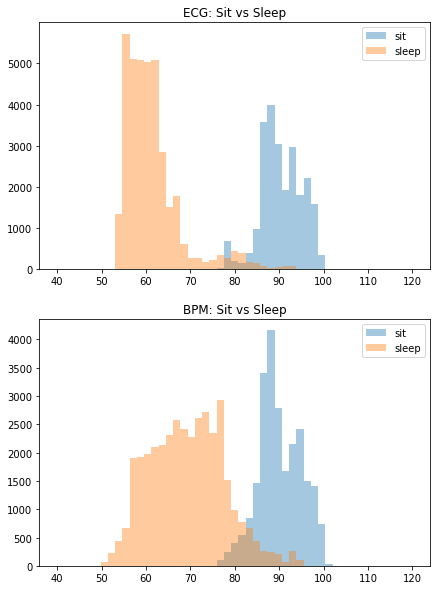

In [ ]:
# EDA(1) - 타겟값 분포 확인 (sit, sleep)
bins = np.linspace(40, 120, 50)
plt.figure(figsize=(7,10))

plt.subplot(211)
plt.title('ECG: Sit vs Sleep')
plt.hist(data_05_sit['ecg'], bins, alpha = 0.4, label = 'sit')
plt.hist(data_10_sleep['ecg'], bins, alpha = 0.4, label = 'sleep')
plt.legend()

plt.subplot(212)
plt.title('BPM: Sit vs Sleep')
plt.hist(data_05_sit['bpm'], bins, alpha = 0.4, label = 'sit')
plt.hist(data_10_sleep['bpm'], bins, alpha = 0.4, label = 'sleep')
plt.legend()

plt.show()

#### 알 수 있는 정보
1. 보통 앉아 있을 때 보다 잠잘 때 ecg, bpm이 더 낮음.
    - 각 자세별로 ecg 측정을 동일인이 하지 않음을 감안하더라도 꽤 차이가 남.  
    (Reference: Heart Rate During Sleep: Implications for Monitoring Training Status. Miriam R. Waldeck and Michael I. Lambert. 2003. Journal of Sports Science and Medicine)

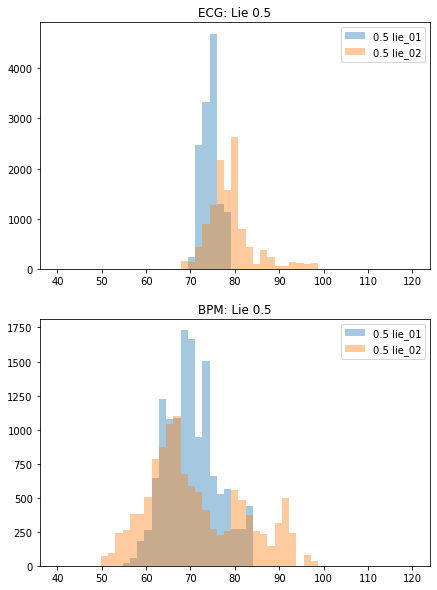

In [ ]:
# 타겟값 분포 확인 (0.5_lie)
bins = np.linspace(40, 120, 50)
plt.figure(figsize=(7,10))

plt.subplot(211)
plt.title('ECG: Lie 0.5')
plt.hist(data_05_lie_01['ecg'], bins, alpha = 0.4, label = '0.5 lie_01') #ksj
plt.hist(data_05_lie_02['ecg'], bins, alpha = 0.4, label = '0.5 lie_02') #chc
plt.legend()

plt.subplot(212)
plt.title('BPM: Lie 0.5')
plt.hist(data_05_lie_01['bpm'], bins, alpha = 0.4, label = '0.5 lie_01') #ksj
plt.hist(data_05_lie_02['bpm'], bins, alpha = 0.4, label = '0.5 lie_02') #chc
plt.legend()

plt.show()

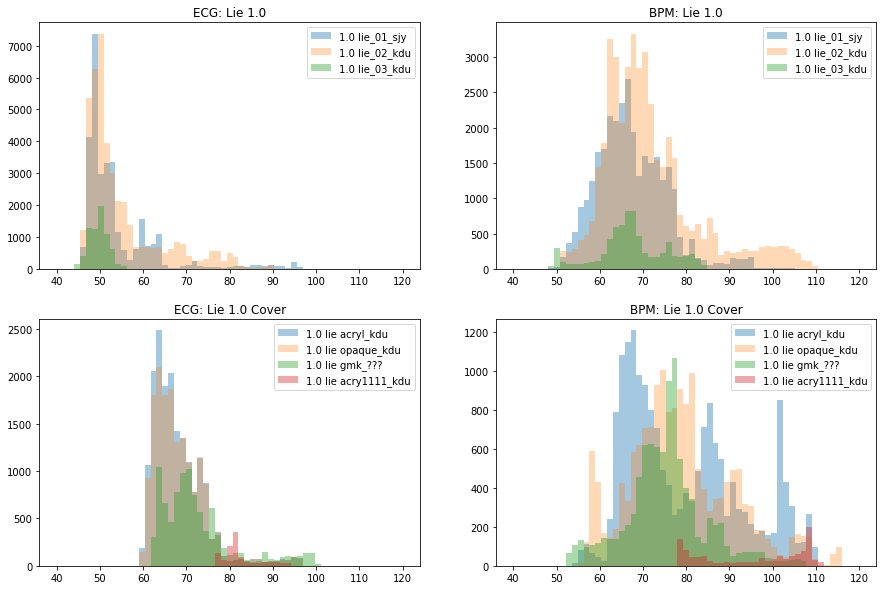

In [ ]:
# 타겟값 분포 확인 (1.0_lie)
bins = np.linspace(40, 120, 60)
plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.title('ECG: Lie 1.0')
plt.hist(data_10_lie_01['ecg'], bins, alpha = 0.4, label = '1.0 lie_01_sjy') #sjy
plt.hist(data_10_lie_02['ecg'], bins, alpha = 0.3, label = '1.0 lie_02_kdu') #kdu
plt.hist(data_10_lie_03['ecg'], bins, alpha = 0.4, label = '1.0 lie_03_kdu') #kdu
plt.legend()

plt.subplot(222)
plt.title('BPM: Lie 1.0')
plt.hist(data_10_lie_01['bpm'], bins, alpha = 0.4, label = '1.0 lie_01_sjy') #sjy
plt.hist(data_10_lie_02['bpm'], bins, alpha = 0.3, label = '1.0 lie_02_kdu') #kdu
plt.hist(data_10_lie_03['bpm'], bins, alpha = 0.4, label = '1.0 lie_03_kdu') #kdu
plt.legend()

plt.subplot(223)
plt.title('ECG: Lie 1.0 Cover')
plt.hist(data_10_lie_acryl['ecg'], bins, alpha = 0.4, label = '1.0 lie acryl_kdu') #kdu
plt.hist(data_10_lie_opaque['ecg'], bins, alpha = 0.3, label = '1.0 lie opaque_kdu') #kdu
plt.hist(data_10_lie_gmk['ecg'], bins, alpha = 0.4, label = '1.0 lie gmk_???') #???
plt.hist(data_10_lie_acryl111['ecg'], bins, alpha = 0.4, label = '1.0 lie acry1111_kdu') #kdu
plt.legend()

plt.subplot(224)
plt.title('BPM: Lie 1.0 Cover')
plt.hist(data_10_lie_acryl['bpm'], bins, alpha = 0.4, label = '1.0 lie acryl_kdu') #kdu
plt.hist(data_10_lie_opaque['bpm'], bins, alpha = 0.3, label = '1.0 lie opaque_kdu') #kdu
plt.hist(data_10_lie_gmk['bpm'], bins, alpha = 0.4, label = '1.0 lie gmk_???') #none
plt.hist(data_10_lie_acryl111['bpm'], bins, alpha = 0.4, label = '1.0 lie acry1111_kdu') #kdu
plt.legend()

plt.show()

#### 알 수 있는 정보
1. Cover의 유무에 따라 ECG 분포 그래프들의 모양이 비슷하다.
2. Cover를 씌우지 않았을 때 BPM 분포 그래프들의 모양은 정규분포 형태에 가까운 반면 Cover를 씌웠을 때 BPM 분포 그래프들의 모양은 opaque, gmk 데이터만 정규분포에 가깝다.
3. arcyl, opaque의 ECG 분포가 상당히 유사하지만, BPM에서는 그렇지 않다.
4. Cover를 씌우지 않은 데이터들의 ECG 분포가 서로 유사하다.  

\

####결론 및 방향성
1. Cover를 씌우지 않은 각각의 Lie 데이터들 (Lie 0.5, Lie 1.0)에 대한 ECG 분포가 각 데이터들간 약간의 차이가 있지만, 범용으로 사용할 수 있는 머신러닝 모델을 모델링 하는 것이라는 목적성을 고려했을때 그 차이는 유의미하게 클 정도는 아니라고 판단해 데이터를 합치는 것이 좋을 것 같다.

2. Cover를 씌운 Lie 1.0 데이터들에 대한 ECG 분포도 마찬가지로 acry1111 커버 데이터를 제외하면 큰 차이는 없어 보이지만, BPM 분포가 너무 천차만별이고, 자세(Lie)와 거리(1.0)는 같지만 "Cover 종류" 라는 확실한 독립변수가 있기 때문에 Cover를 씌운 데이터는 합치지 않으려 한다.

> **데이터를 합쳐보자.**  

### Preprocessing (2) - 데이터 합치기

In [ ]:
#전처리 (2) - 측정 거리, 자세별 데이터 합치기
data_05_lie = pd.concat([data_05_lie_01, data_05_lie_02], axis = 0)
data_10_lie = pd.concat([data_10_lie_01, data_10_lie_02, data_10_lie_03], axis = 0)

#Reset index
data_05_sit.reset_index(drop = True, inplace = True)
data_10_sleep.reset_index(drop = True, inplace = True)
data_05_lie.reset_index(drop = True, inplace = True)
data_10_lie.reset_index(drop = True, inplace = True)
data_10_lie_acryl.reset_index(drop = True, inplace = True)
data_10_lie_opaque.reset_index(drop = True, inplace = True)
data_10_lie_gmk.reset_index(drop = True, inplace = True)
data_10_lie_acryl111.reset_index(drop = True, inplace = True)

In [ ]:
#데이터 크기 확인
print(data_05_sit.shape)
print(data_10_sleep.shape)
print(data_05_lie.shape)
print(data_10_lie.shape)
print(data_10_lie_acryl.shape)
print(data_10_lie_opaque.shape)
print(data_10_lie_gmk.shape)
print(data_10_lie_acryl111.shape)

(23938, 15)
(37148, 15)
(25027, 15)
(81401, 15)
(17946, 15)
(16731, 15)
(9555, 15)
(1151, 15)


### EDA(2) - 최종 타겟값 분포 확인

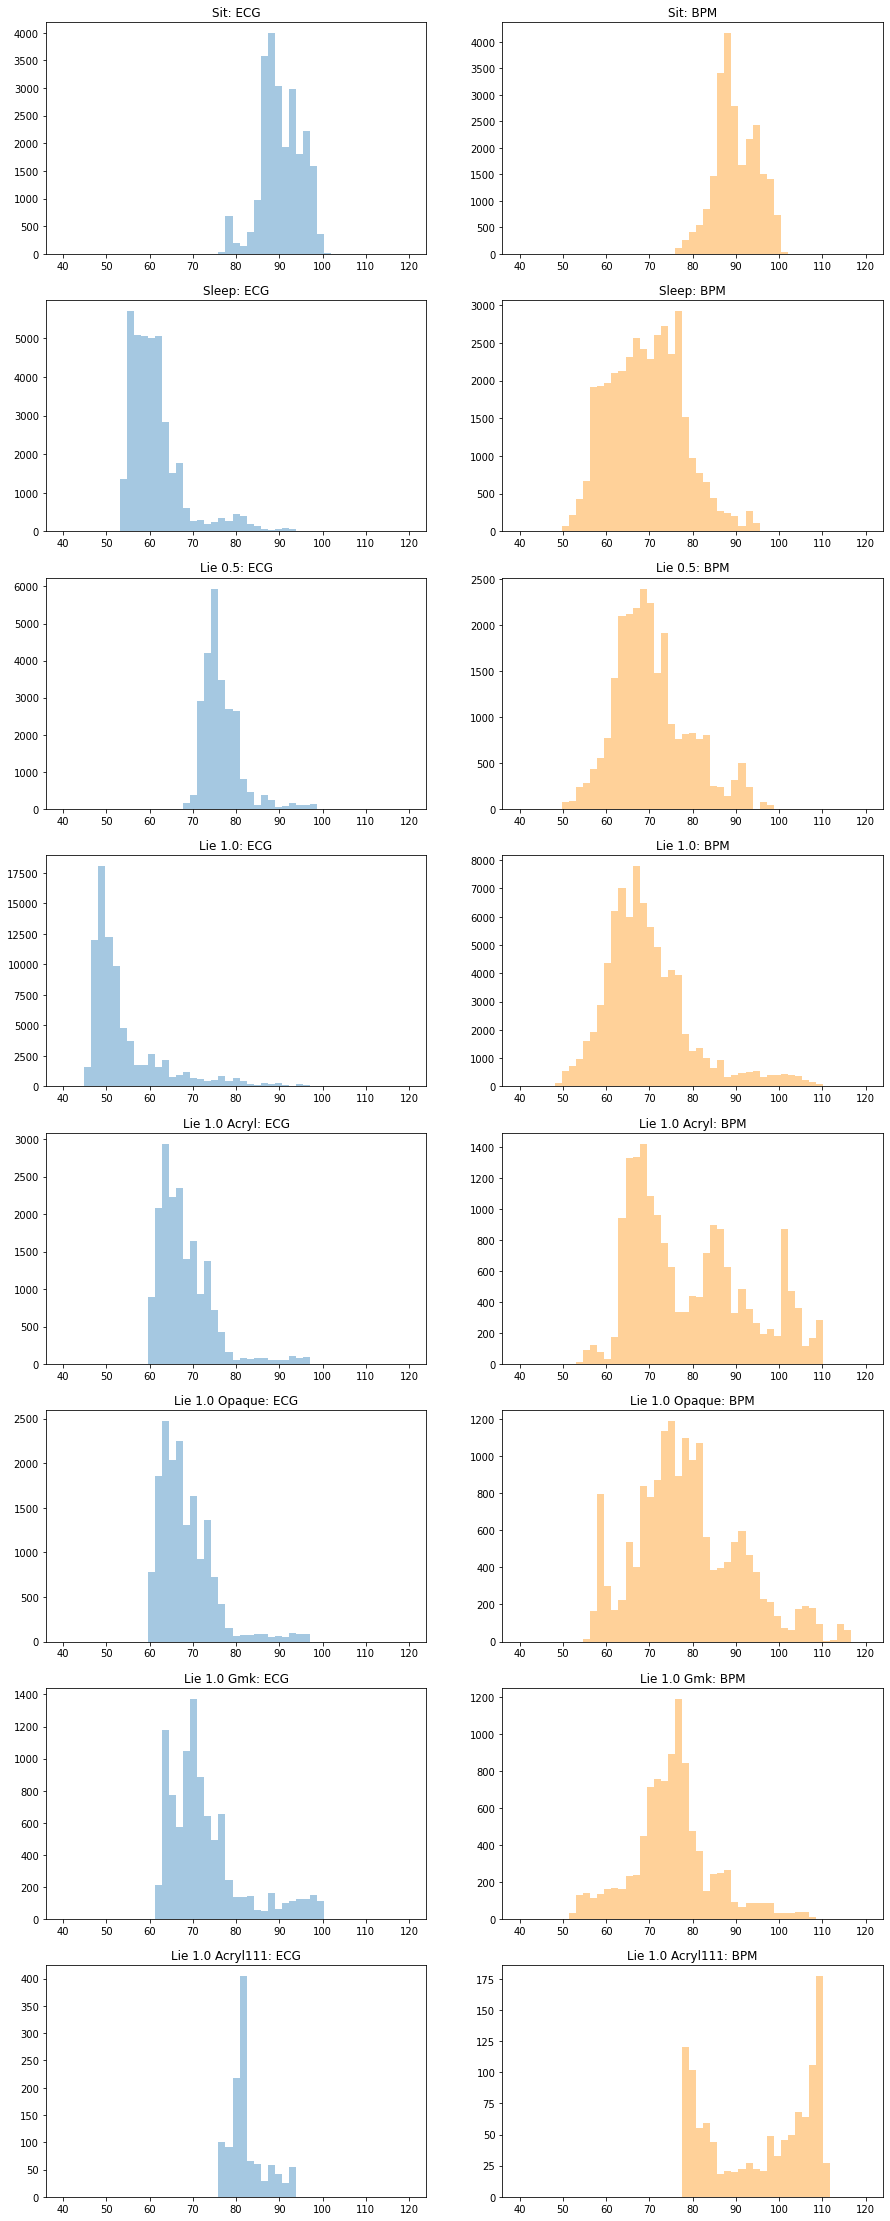

In [ ]:
# 타겟값 분포 확인
bins = np.linspace(40, 120, 50)
plt.figure(figsize=(15, 40))

plt.subplot(8, 2, 1)
plt.title('Sit: ECG')
plt.hist(data_05_sit['ecg'], bins, alpha = 0.4, label = 'sit')

plt.subplot(8, 2, 2)
plt.title('Sit: BPM')
plt.hist(data_05_sit['bpm'], bins, alpha = 0.4, label = 'sit', color = "darkorange")

plt.subplot(8, 2, 3)
plt.title('Sleep: ECG')
plt.hist(data_10_sleep['ecg'], bins, alpha = 0.4, label = 'sleep')

plt.subplot(8, 2, 4)
plt.title('Sleep: BPM')
plt.hist(data_10_sleep['bpm'], bins, alpha = 0.4, label = 'sleep', color = "darkorange")

plt.subplot(8, 2, 5)
plt.title('Lie 0.5: ECG')
plt.hist(data_05_lie['ecg'], bins, alpha = 0.4, label = 'lie_05')

plt.subplot(8, 2, 6)
plt.title('Lie 0.5: BPM')
plt.hist(data_05_lie['bpm'], bins, alpha = 0.4, label = 'lie_05', color = "darkorange")

plt.subplot(8, 2, 7)
plt.title('Lie 1.0: ECG')
plt.hist(data_10_lie['ecg'], bins, alpha = 0.4, label = 'lie_10')

plt.subplot(8, 2, 8)
plt.title('Lie 1.0: BPM')
plt.hist(data_10_lie['bpm'], bins, alpha = 0.4, label = 'lie_10', color = "darkorange")

plt.subplot(8, 2, 9)
plt.title('Lie 1.0 Acryl: ECG')
plt.hist(data_10_lie_acryl['ecg'], bins, alpha = 0.4, label = 'lie_10_acryl')

plt.subplot(8, 2, 10)
plt.title('Lie 1.0 Acryl: BPM')
plt.hist(data_10_lie_acryl['bpm'], bins, alpha = 0.4, label = 'lie_10_acryl', color = "darkorange")

plt.subplot(8, 2, 11)
plt.title('Lie 1.0 Opaque: ECG')
plt.hist(data_10_lie_opaque['ecg'], bins, alpha = 0.4, label = 'lie_10_opaque')

plt.subplot(8, 2, 12)
plt.title('Lie 1.0 Opaque: BPM')
plt.hist(data_10_lie_opaque['bpm'], bins, alpha = 0.4, label = 'lie_10_opaque', color = "darkorange")

plt.subplot(8, 2, 13)
plt.title('Lie 1.0 Gmk: ECG')
plt.hist(data_10_lie_gmk['ecg'], bins, alpha = 0.4, label = 'lie_10_gmk')

plt.subplot(8, 2, 14)
plt.title('Lie 1.0 Gmk: BPM')
plt.hist(data_10_lie_gmk['bpm'], bins, alpha = 0.4, label = 'lie_10_gmk', color = "darkorange")

plt.subplot(8, 2, 15)
plt.title('Lie 1.0 Acryl111: ECG')
plt.hist(data_10_lie_acryl111['ecg'], bins, alpha = 0.4, label = 'lie_10_acryl111')

plt.subplot(8, 2, 16)
plt.title('Lie 1.0 Acryl111: BPM')
plt.hist(data_10_lie_acryl111['bpm'], bins, alpha = 0.4, label = 'lie_10_acryl111', color = "darkorange")

plt.show()

#### 알 수 있는 정보
1. 대체로 ECG보다 BPM이 더 정규분포에 가까운 형태를 띠고 있음.
2. 특히 lie 0.5와 lie 1.0 그리고 sleep까지의 BPM 그래프가 유사함.

### Preprocessing (3) - 결측치 확인 및 bin_var, motion_energy 이상치 제거

In [ ]:
#결측치 확인
print(data_05_sit.isnull().sum().sum())
print(data_10_sleep.isnull().sum().sum())
print(data_05_lie.isnull().sum().sum())
print(data_10_lie.isnull().sum().sum())
print(data_10_lie_acryl.isnull().sum().sum())
print(data_10_lie_opaque.isnull().sum().sum())
print(data_10_lie_gmk.isnull().sum().sum())
print(data_10_lie_acryl111.isnull().sum().sum())

0
0
0
0
0
0
0
0


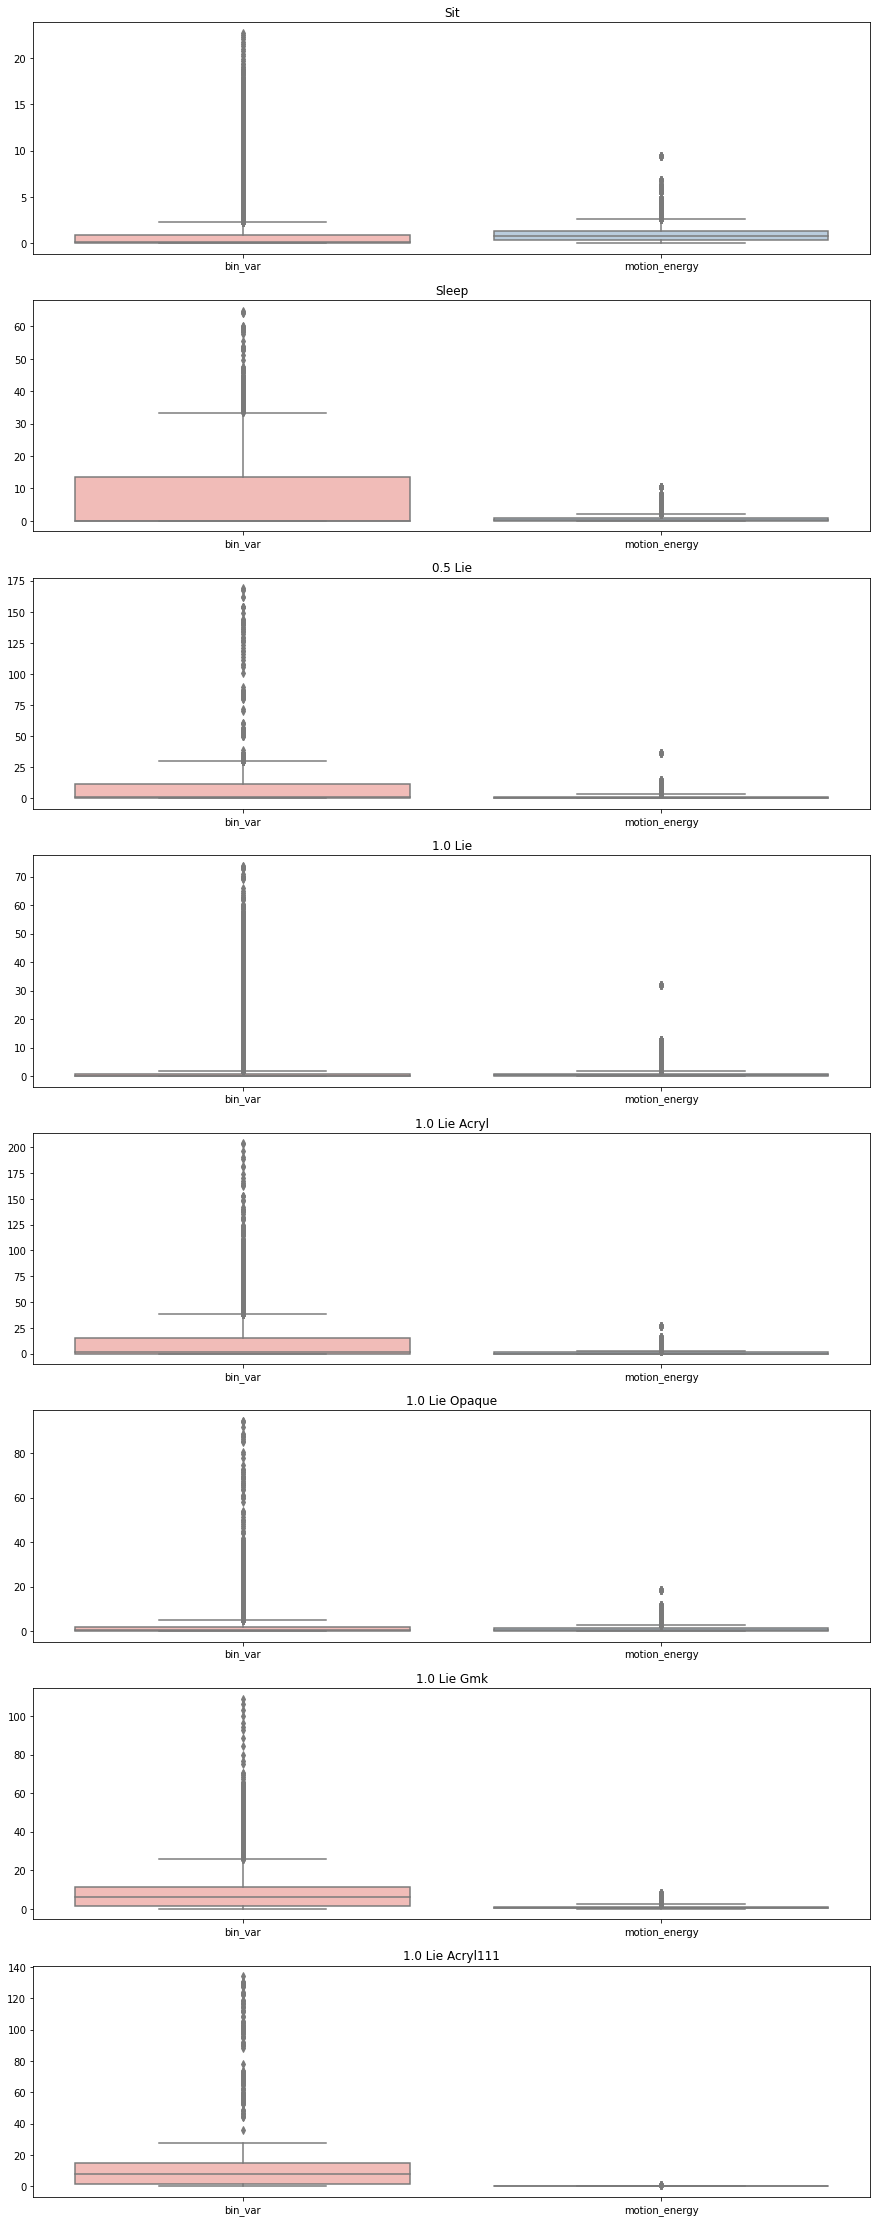

In [ ]:
#전처리(3) - 이상치 확인 및 제거 (1) - bin_var, motion_energy
data_05_sit_outlier_plot = data_05_sit.loc[:, ['bin_var', 'motion_energy']]
data_10_sleep_outlier_plot = data_10_sleep.loc[:, ['bin_var', 'motion_energy']]
data_05_lie_outlier_plot = data_05_lie.loc[:, ['bin_var', 'motion_energy']]
data_10_lie_outlier_plot = data_10_lie.loc[:, ['bin_var', 'motion_energy']]
data_10_lie_acryl_outlier_plot = data_10_lie_acryl.loc[:, ['bin_var', 'motion_energy']]
data_10_lie_opaque_outlier_plot = data_10_lie_opaque.loc[:, ['bin_var', 'motion_energy']]
data_10_lie_gmk_outlier_plot = data_10_lie_gmk.loc[:, ['bin_var', 'motion_energy']]
data_10_lie_acryl111_outlier_plot = data_10_lie_acryl111.loc[:, ['bin_var', 'motion_energy']]

plt.figure(figsize=(15, 40))

plt.subplot(811)
plt.title('Sit')
sns.boxplot(data = data_05_sit_outlier_plot, palette = 'Pastel1')

plt.subplot(812)
plt.title('Sleep')
sns.boxplot(data = data_10_sleep_outlier_plot, palette = 'Pastel1')

plt.subplot(813)
plt.title('0.5 Lie')
sns.boxplot(data = data_05_lie_outlier_plot, palette = 'Pastel1')

plt.subplot(814)
plt.title('1.0 Lie')
sns.boxplot(data = data_10_lie_outlier_plot, palette = 'Pastel1')

plt.subplot(815)
plt.title('1.0 Lie Acryl')
sns.boxplot(data = data_10_lie_acryl_outlier_plot, palette = 'Pastel1')

plt.subplot(816)
plt.title('1.0 Lie Opaque')
sns.boxplot(data = data_10_lie_opaque_outlier_plot, palette = 'Pastel1')

plt.subplot(817)
plt.title('1.0 Lie Gmk')
sns.boxplot(data = data_10_lie_gmk_outlier_plot, palette = 'Pastel1')

plt.subplot(818)
plt.title('1.0 Lie Acryl111')
sns.boxplot(data = data_10_lie_acryl111_outlier_plot, palette = 'Pastel1')


plt.show()

In [ ]:
def outliers_iqr(data):
    #outlier를 선별하는 함수
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)

    return np.where((data > upper_bound) | (data < lower_bound))

def motion_outlier_index(dataframe):
    #outlier index를 반환하는 함수
    bin_var_outlier_index = outliers_iqr(dataframe["bin_var"])[0]
    motion_energy_outlier_index = outliers_iqr(dataframe["motion_energy"])[0]

    lead_outlier_index = np.concatenate((bin_var_outlier_index, motion_energy_outlier_index), axis = None)
    return lead_outlier_index

<참고 이미지>

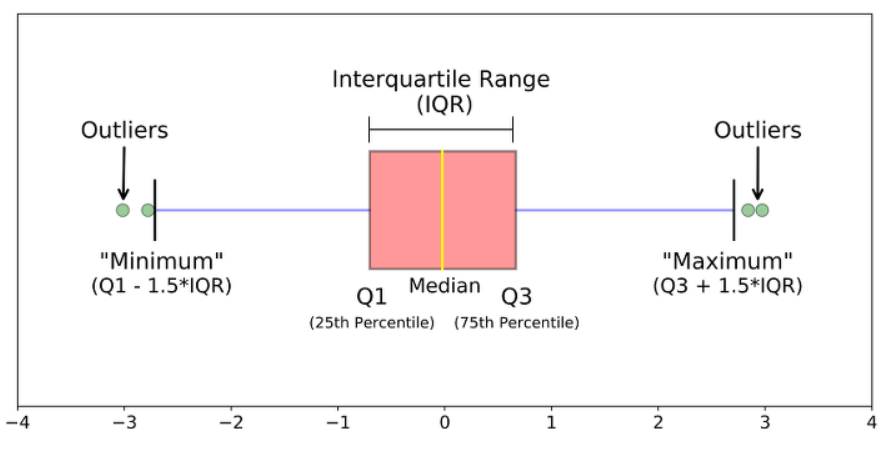

In [ ]:
sit_lead_outlier_index = motion_outlier_index(data_05_sit)
sleep_lead_outlier_index = motion_outlier_index(data_10_sleep)
lie_05_lead_outlier_index = motion_outlier_index(data_05_lie)
lie_10_lead_outlier_index = motion_outlier_index(data_10_lie)
lie_10_acryl_lead_outlier_index = motion_outlier_index(data_10_lie_acryl)
lie_10_opaque_lead_outlier_index = motion_outlier_index(data_10_lie_opaque)
lie_10_gmk_lead_outlier_index = motion_outlier_index(data_10_lie_gmk)
lie_10_acryl111_lead_outlier_index = motion_outlier_index(data_10_lie_acryl111)

print(len(sit_lead_outlier_index))
print(len(sleep_lead_outlier_index))
print(len(lie_05_lead_outlier_index))
print(len(lie_10_lead_outlier_index))
print(len(lie_10_acryl_lead_outlier_index))
print(len(lie_10_opaque_lead_outlier_index))
print(len(lie_10_gmk_lead_outlier_index))
print(len(lie_10_acryl111_lead_outlier_index))

3176
4026
2653
19925
3323
3499
1060
154


In [ ]:
data_sit_clean = data_05_sit.drop(sit_lead_outlier_index).reset_index(drop = True)
data_sleep_clean = data_10_sleep.drop(sleep_lead_outlier_index).reset_index(drop = True)
data_lie_05_clean = data_05_lie.drop(lie_05_lead_outlier_index).reset_index(drop = True)
data_lie_10_clean = data_10_lie.drop(lie_10_lead_outlier_index).reset_index(drop = True)
data_lie_10_acryl_clean = data_10_lie_acryl.drop(lie_10_acryl_lead_outlier_index).reset_index(drop = True)
data_lie_10_opaque_clean = data_10_lie_opaque.drop(lie_10_opaque_lead_outlier_index).reset_index(drop = True)
data_lie_10_gmk_clean = data_10_lie_gmk.drop(lie_10_gmk_lead_outlier_index).reset_index(drop = True)
data_lie_10_acryl111_clean = data_10_lie_acryl111.drop(lie_10_acryl111_lead_outlier_index).reset_index(drop = True)

In [ ]:
#확인
print(data_sit_clean.shape)
print(data_sleep_clean.shape)
print(data_lie_05_clean.shape)
print(data_lie_10_clean.shape)
print(data_lie_10_acryl_clean.shape)
print(data_lie_10_opaque_clean.shape)
print(data_lie_10_gmk_clean.shape)
print(data_lie_10_acryl111_clean.shape)

(20824, 15)
(33285, 15)
(22386, 15)
(64431, 15)
(14704, 15)
(13578, 15)
(8505, 15)
(997, 15)


### Preprocessing (4) - bin, fft 이상치 확인 및 제거

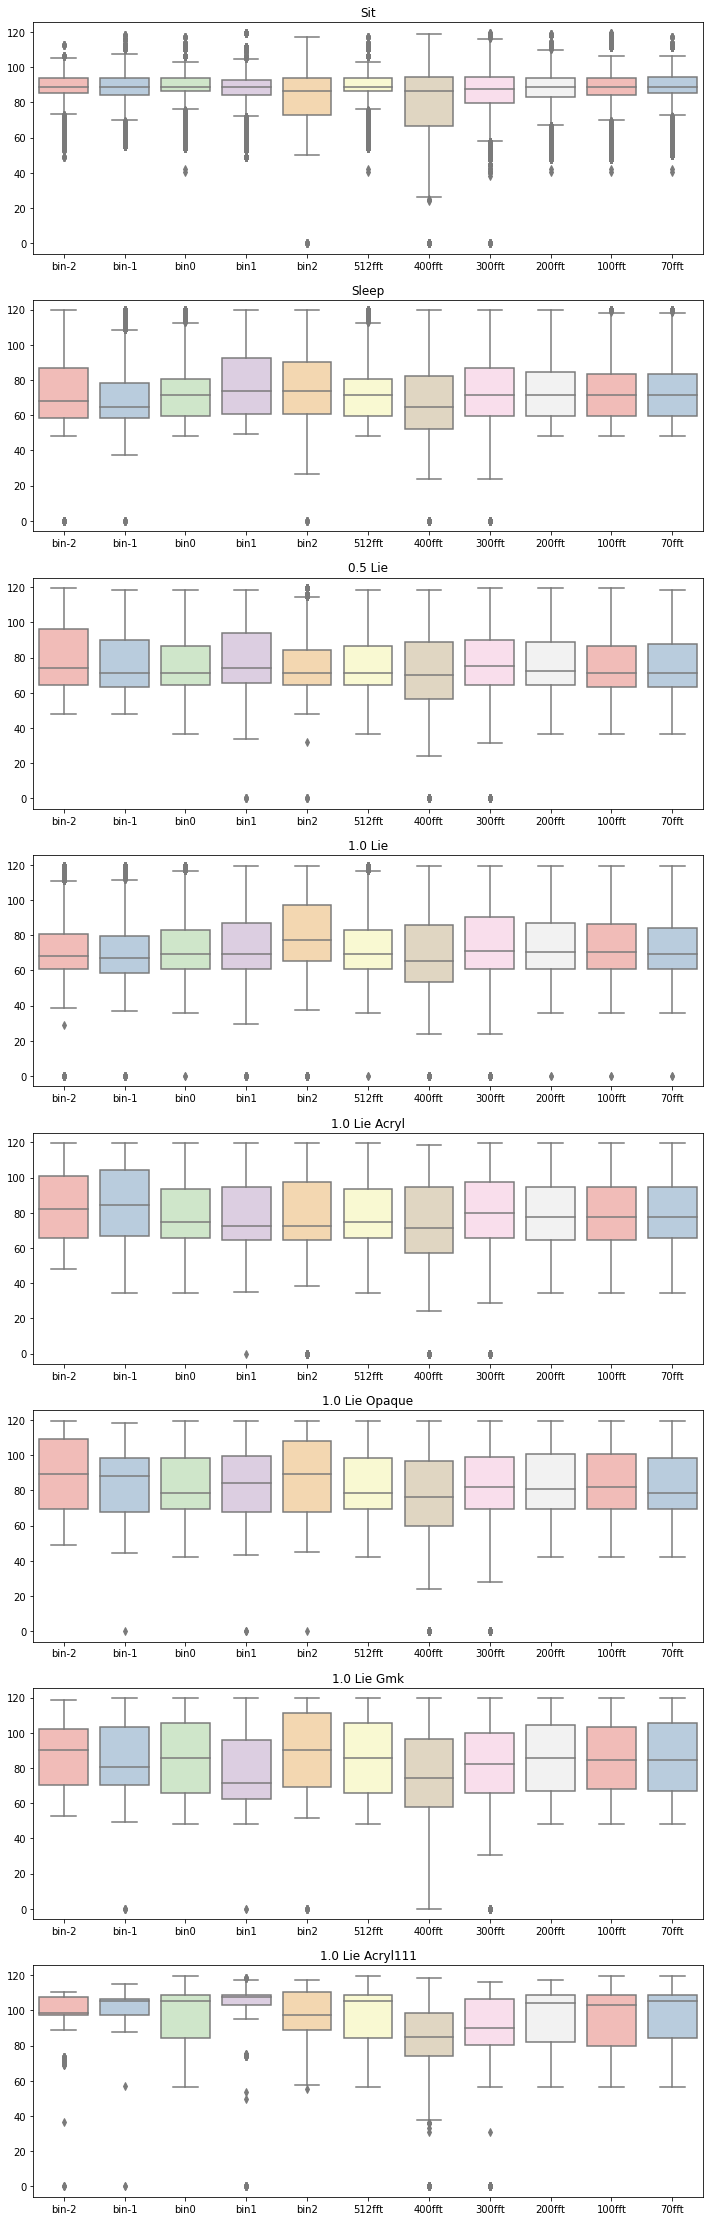

In [ ]:
#전처리(4) - bin, fft 이상치 확인 및 제거
data_sit_plot = data_sit_clean.loc[:, "bin-2" : "70fft"]
data_sleep_plot = data_sleep_clean.loc[:, "bin-2" : "70fft"]
data_lie_05_plot = data_lie_05_clean.loc[:, "bin-2" : "70fft"]
data_lie_10_plot = data_lie_10_clean.loc[:, "bin-2" : "70fft"]
data_lie_10_acryl_plot = data_lie_10_acryl_clean.loc[:, "bin-2" : "70fft"]
data_lie_10_opaque_plot = data_lie_10_opaque_clean.loc[:, "bin-2" : "70fft"]
data_lie_10_gmk_plot = data_lie_10_gmk_clean.loc[:, "bin-2" : "70fft"]
data_lie_10_acryl111_plot = data_lie_10_acryl111_clean.loc[:, "bin-2" : "70fft"]

plt.figure(figsize=(12, 40))

plt.subplot(811)
plt.title('Sit')
sns.boxplot(data = data_sit_plot, palette = 'Pastel1')

plt.subplot(812)
plt.title('Sleep')
sns.boxplot(data = data_sleep_plot, palette = 'Pastel1')

plt.subplot(813)
plt.title('0.5 Lie')
sns.boxplot(data = data_lie_05_plot, palette = 'Pastel1')

plt.subplot(814)
plt.title('1.0 Lie')
sns.boxplot(data = data_lie_10_plot, palette = 'Pastel1')

plt.subplot(815)
plt.title('1.0 Lie Acryl')
sns.boxplot(data = data_lie_10_acryl_plot, palette = 'Pastel1')

plt.subplot(816)
plt.title('1.0 Lie Opaque')
sns.boxplot(data = data_lie_10_opaque_plot, palette = 'Pastel1')

plt.subplot(817)
plt.title('1.0 Lie Gmk')
sns.boxplot(data = data_lie_10_gmk_plot, palette = 'Pastel1')

plt.subplot(818)
plt.title('1.0 Lie Acryl111')
sns.boxplot(data = data_lie_10_acryl111_plot, palette = 'Pastel1')

plt.show()

In [ ]:
def bin_fft_outlier_index(dataframe):
    #outlier index를 반환하는 함수
    bin_2_outlier_index = outliers_iqr(dataframe["bin-2"])[0]
    bin_1_outlier_index = outliers_iqr(dataframe["bin-1"])[0]
    bin_0_outlier_index = outliers_iqr(dataframe["bin0"])[0]
    bin1_outlier_index = outliers_iqr(dataframe["bin1"])[0]
    bin2_outlier_index = outliers_iqr(dataframe["bin2"])[0]

    fft_512_outlier_index = outliers_iqr(dataframe["512fft"])[0]
    fft_400_outlier_index = outliers_iqr(dataframe["400fft"])[0]
    fft_300_outlier_index = outliers_iqr(dataframe["300fft"])[0]
    fft_200_outlier_index = outliers_iqr(dataframe["200fft"])[0]
    fft_100_outlier_index = outliers_iqr(dataframe["100fft"])[0]
    fft_70_outlier_index = outliers_iqr(dataframe["70fft"])[0]

    lead_outlier_index = np.concatenate((bin_2_outlier_index,
                                         bin_1_outlier_index,
                                         bin_0_outlier_index,
                                         bin1_outlier_index,
                                         bin2_outlier_index,
                                         fft_512_outlier_index,
                                         fft_400_outlier_index,
                                         fft_300_outlier_index,
                                         fft_200_outlier_index,
                                         fft_100_outlier_index,
                                         fft_70_outlier_index), axis = None)
    return lead_outlier_index

In [ ]:
sit_lead_outlier_index = bin_fft_outlier_index(data_sit_clean)
sleep_lead_outlier_index = bin_fft_outlier_index(data_sleep_clean)
lie_05_lead_outlier_index = bin_fft_outlier_index(data_lie_05_clean)
lie_10_lead_outlier_index = bin_fft_outlier_index(data_lie_10_clean)
lie_10_acryl_lead_outlier_index = bin_fft_outlier_index(data_lie_10_acryl_clean)
lie_10_opaque_lead_outlier_index = bin_fft_outlier_index(data_lie_10_opaque_clean)
lie_10_gmk_lead_outlier_index = bin_fft_outlier_index(data_lie_10_gmk_clean)
lie_10_acryl111_lead_outlier_index = bin_fft_outlier_index(data_lie_10_acryl111_clean)

print(len(sit_lead_outlier_index))
print(len(sleep_lead_outlier_index))
print(len(lie_05_lead_outlier_index))
print(len(lie_10_lead_outlier_index))
print(len(lie_10_acryl_lead_outlier_index))
print(len(lie_10_opaque_lead_outlier_index ))
print(len(lie_10_gmk_lead_outlier_index))
print(len(lie_10_acryl111_lead_outlier_index))

19579
11156
3287
15673
2252
1878
87
302


In [ ]:
data_sit_clean_01 = data_sit_clean.drop(sit_lead_outlier_index).reset_index(drop = True)
data_sleep_clean_01 = data_sleep_clean.drop(sleep_lead_outlier_index).reset_index(drop = True)
data_lie_05_clean_01 = data_lie_05_clean.drop(lie_05_lead_outlier_index).reset_index(drop = True)
data_lie_10_clean_01 = data_lie_10_clean.drop(lie_10_lead_outlier_index).reset_index(drop = True)
data_lie_10_acryl_clean_01 = data_lie_10_acryl_clean.drop(lie_10_acryl_lead_outlier_index).reset_index(drop = True)
data_lie_10_opaque_clean_01 = data_lie_10_opaque_clean.drop(lie_10_opaque_lead_outlier_index).reset_index(drop = True)
data_lie_10_gmk_clean_01 = data_lie_10_gmk_clean.drop(lie_10_gmk_lead_outlier_index).reset_index(drop = True)
data_lie_10_acryl111_clean_01 = data_lie_10_acryl111_clean.drop(lie_10_acryl111_lead_outlier_index).reset_index(drop = True)


#확인
print(data_sit_clean_01.shape)              # 23938 >> 12133    (50.59 %)
print(data_sleep_clean_01.shape)            # 37148 >> 25041    (67.41 %)
print(data_lie_05_clean_01.shape)           # 25027 >> 19236    (76.86 %)
print(data_lie_10_clean_01.shape)           # 81401 >> 51297    (63.02 %)
print(data_lie_10_acryl_clean_01.shape)     # 17946 >> 12537    (69.86 %)
print(data_lie_10_opaque_clean_01.shape)    # 16731 >> 11744    (70.19 %)
print(data_lie_10_gmk_clean_01.shape)       # 9555  >> 8427     (88.19 %)
print(data_lie_10_acryl111_clean_01.shape)  # 1151  >> 781      (67.85 %)

(12133, 15)
(25041, 15)
(19236, 15)
(51297, 15)
(12587, 15)
(11744, 15)
(8427, 15)
(781, 15)


In [ ]:
#bin_var와 motion_energy feature에 대한 outlier를 제거할 때 사용한 기법인
#사분위값(Quartile)을 이용해서 bin, fft feature에 대한 outlier를 제거하면 데이터 손실이 너무 크다.

In [ ]:
#그리고 fft나 bin값 모두 0 ~ 120의 값을 가짐.
#120이 outlier라고 생각되지 않음.

#또한 시각화 한 데이터는 fft값에 대한 전처리를 마친 데이터이기 때문에
#측정불량을 의미하는 0에 대한 값이 있어도 feature에서는 측정이 되었을 것이기 때문에
#측정값 0을 포함하는 데이터를 삭제하지 않고 이후 과정을 진행하였음.

#결론: bin, fft에 대한 outlier는 제거없이 진행하였음.

### Preprocessing (5) - 다중공선성 문제완화

In [ ]:
#전처리 (4) - 상관관계 분석 (다중공선성 문제 해결)

#상관관계 분석 
data_sit_corr = data_sit_clean.loc[:, "bin-2" : "70fft"]
data_sleep_corr = data_sleep_clean.loc[:, "bin-2" : "70fft"]
data_lie_05_corr = data_lie_05_clean.loc[:, "bin-2" : "70fft"]
data_lie_10_corr = data_lie_10_clean.loc[:, "bin-2" : "70fft"]
data_lie_10_acryl_corr = data_lie_10_acryl_clean.loc[:, "bin-2" : "70fft"]
data_lie_10_opaque_corr = data_lie_10_opaque_clean.loc[:, "bin-2" : "70fft"]
data_lie_10_gmk_corr = data_lie_10_gmk_clean.loc[:, "bin-2" : "70fft"]
data_lie_10_acryl111_corr = data_lie_10_acryl111_clean.loc[:, "bin-2" : "70fft"]

sit_cor = data_sit_corr.corr()
sleep_cor = data_sleep_corr.corr()
lie_05_cor = data_lie_05_corr.corr()
lie_10_cor = data_lie_10_corr.corr()
lie_10_acryl_cor = data_lie_10_acryl_corr.corr()
lie_10_opaque_cor = data_lie_10_opaque_corr.corr()
lie_10_gmk_cor = data_lie_10_gmk_corr.corr()
lie_10_acryl111_cor = data_lie_10_acryl111_corr.corr()

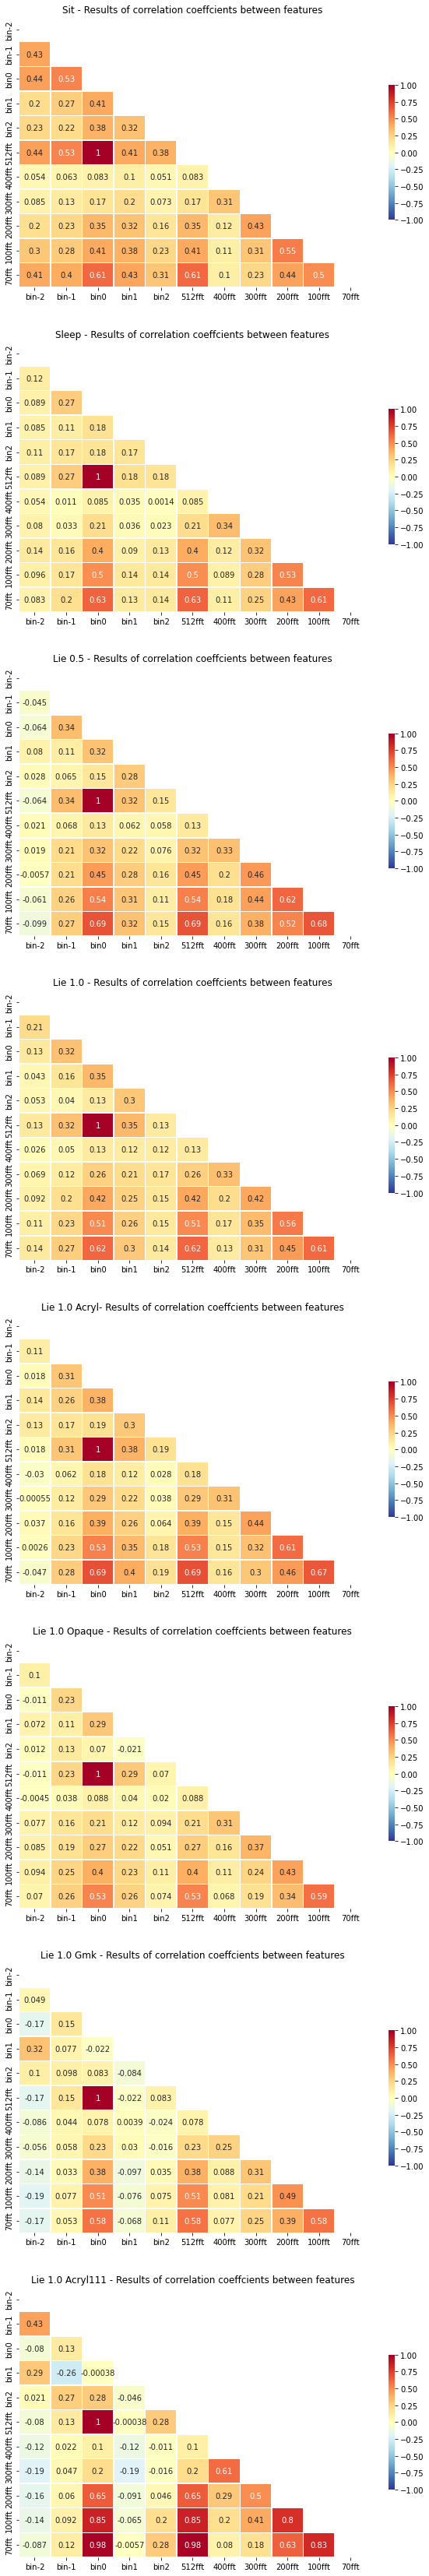

In [ ]:
#Visualization
plt.figure(figsize=(10, 60))

#Mask
mask = np.zeros_like(sit_cor, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

#Heatmap
plt.subplot(811)
plt.title('Sit - Results of correlation coeffcients between features')
sns.heatmap(sit_cor, 
            cmap = 'RdYlBu_r', # 컬러
            annot = True,      # 값 표시
            mask=mask,         # 표시하지 않을 마스크 부분을 지정
            linewidths=.5,     # 경계면 실선
            cbar_kws={"shrink": .5},  # 컬러바 크기
            vmin = -1, vmax = 1        # 컬러바 범위 -1 ~ 1
            ) 

plt.subplot(812)
plt.title('Sleep - Results of correlation coeffcients between features')
sns.heatmap(sleep_cor, 
            cmap = 'RdYlBu_r', # 컬러
            annot = True,      # 값 표시
            mask=mask,         # 표시하지 않을 마스크 부분을 지정
            linewidths=.5,     # 경계면 실선
            cbar_kws={"shrink": .5},  # 컬러바 크기
            vmin = -1, vmax = 1        # 컬러바 범위 -1 ~ 1
            )

plt.subplot(813)
plt.title('Lie 0.5 - Results of correlation coeffcients between features')
sns.heatmap(lie_05_cor, 
            cmap = 'RdYlBu_r', # 컬러
            annot = True,      # 값 표시
            mask=mask,         # 표시하지 않을 마스크 부분을 지정
            linewidths=.5,     # 경계면 실선
            cbar_kws={"shrink": .5},  # 컬러바 크기
            vmin = -1, vmax = 1        # 컬러바 범위 -1 ~ 1
            )

plt.subplot(814)
plt.title('Lie 1.0 - Results of correlation coeffcients between features')
sns.heatmap(lie_10_cor, 
            cmap = 'RdYlBu_r', # 컬러
            annot = True,      # 값 표시
            mask=mask,         # 표시하지 않을 마스크 부분을 지정
            linewidths=.5,     # 경계면 실선
            cbar_kws={"shrink": .5},  # 컬러바 크기
            vmin = -1, vmax = 1        # 컬러바 범위 -1 ~ 1
            )

plt.subplot(815)
plt.title('Lie 1.0 Acryl- Results of correlation coeffcients between features')
sns.heatmap(lie_10_acryl_cor, 
            cmap = 'RdYlBu_r', # 컬러
            annot = True,      # 값 표시
            mask=mask,         # 표시하지 않을 마스크 부분을 지정
            linewidths=.5,     # 경계면 실선
            cbar_kws={"shrink": .5},  # 컬러바 크기
            vmin = -1, vmax = 1        # 컬러바 범위 -1 ~ 1
            )

plt.subplot(816)
plt.title('Lie 1.0 Opaque - Results of correlation coeffcients between features')
sns.heatmap(lie_10_opaque_cor, 
            cmap = 'RdYlBu_r', # 컬러
            annot = True,      # 값 표시
            mask=mask,         # 표시하지 않을 마스크 부분을 지정
            linewidths=.5,     # 경계면 실선
            cbar_kws={"shrink": .5},  # 컬러바 크기
            vmin = -1, vmax = 1        # 컬러바 범위 -1 ~ 1
            )

plt.subplot(817)
plt.title('Lie 1.0 Gmk - Results of correlation coeffcients between features')
sns.heatmap(lie_10_gmk_cor, 
            cmap = 'RdYlBu_r', # 컬러
            annot = True,      # 값 표시
            mask=mask,         # 표시하지 않을 마스크 부분을 지정
            linewidths=.5,     # 경계면 실선
            cbar_kws={"shrink": .5},  # 컬러바 크기
            vmin = -1, vmax = 1        # 컬러바 범위 -1 ~ 1
            )

plt.subplot(818)
plt.title('Lie 1.0 Acryl111 - Results of correlation coeffcients between features')
sns.heatmap(lie_10_acryl111_cor, 
            cmap = 'RdYlBu_r', # 컬러
            annot = True,      # 값 표시
            mask=mask,         # 표시하지 않을 마스크 부분을 지정
            linewidths=.5,     # 경계면 실선
            cbar_kws={"shrink": .5},  # 컬러바 크기
            vmin = -1, vmax = 1        # 컬러바 범위 -1 ~ 1
            )

plt.show()

In [ ]:
#512 fft feature 제거 (bin0 와 상관계수 1.0)
data_sit_clean.drop("512fft", axis = 1, inplace = True)
data_sleep_clean.drop("512fft", axis = 1, inplace = True)
data_lie_05_clean.drop("512fft", axis = 1, inplace = True)
data_lie_10_clean.drop("512fft", axis = 1, inplace = True)
data_lie_10_acryl_clean.drop("512fft", axis = 1, inplace = True)
data_lie_10_opaque_clean.drop("512fft", axis = 1, inplace = True)
data_lie_10_gmk_clean.drop("512fft", axis = 1, inplace = True)
data_lie_10_acryl111_clean.drop(["512fft"], axis = 1, inplace = True)

### Preprocessing (6) - PCA

In [ ]:
#목적: 다중공선성 문제를 해결하기 위함.
#   상관계수가 높은 (0.5 이상) feature들이 몇 개 있지만 feature를 삭제하는 대신 PCA를 이용해 해결해보고자 한다.
#참고 url: https://specialscene.tistory.com/11
#
#편의상 데이터셋 8개를 모두 보지 않고 Cover를 씌우지 않은 데이터 4개만 보고
#모델을 정의하기 위한 Pipeline를 구성하는데 포함될 PCA의 n_components를 정해보자.

In [ ]:
#PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

data_sit_features = data_sit_clean.loc[:, "bin-2" : "70fft"]
data_sleep_features = data_sleep_clean.loc[:, "bin-2" : "70fft"]
data_lie_05_features = data_lie_05_clean.loc[:, "bin-2" : "70fft"]
data_lie_10_features = data_lie_10_clean.loc[:, "bin-2" : "70fft"]

sit_scaler = StandardScaler()
sleep_scaler = StandardScaler()
lie_05_scaler = StandardScaler()
lie_10_scaler = StandardScaler()

data_sit_features = sit_scaler.fit_transform(data_sit_features)
data_sleep_features = sleep_scaler.fit_transform(data_sleep_features)
data_lie_05_features = lie_05_scaler.fit_transform(data_lie_05_features)
data_lie_10_features = lie_10_scaler.fit_transform(data_lie_10_features)

In [ ]:
sit_pca = PCA()
sleep_pca = PCA()
lie_05_pca = PCA()
lie_10_pca = PCA()

sit_pca.fit(data_sit_features)
sleep_pca.fit(data_sleep_features)
lie_05_pca.fit(data_lie_05_features)
lie_10_pca.fit(data_lie_10_features)

sit_ratio = sit_pca.explained_variance_ratio_
sleep_ratio = sleep_pca.explained_variance_ratio_
lie_05_ratio = lie_05_pca.explained_variance_ratio_
lie_10_ratio = lie_10_pca.explained_variance_ratio_

In [ ]:
labels = ["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10"]

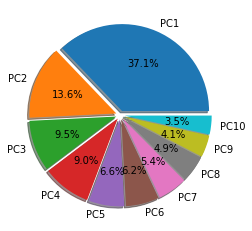

[0.371394   0.13639296 0.09498732 0.0898246  0.06572339 0.06169903
 0.05446283 0.04942593]


0.9239100607479848

In [ ]:
#Sit data
plt.pie(sit_ratio, labels = labels, autopct = "%.1f%%", explode = [0.05] * 10, shadow = True)
plt.show()

#PC1 ~ PC6까지의 주성분이 전체 분산의 약 92%를 설명함.
print(sit_ratio[:8])
sum(sit_ratio[:8])

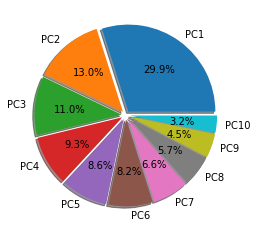

[0.29894643 0.12959372 0.10959514 0.0929043  0.08637048 0.08196575
 0.06636849 0.05738778]


0.9231320899828059

In [ ]:
#Sleep data
plt.pie(sleep_ratio, labels = labels, autopct = "%.1f%%", explode = [0.05] * 10, shadow = True)
plt.show()

#PC1 ~ PC6까지의 주성분이 전체 분산의 약 92%를 설명함.
print(sleep_ratio[:8])
sum(sleep_ratio[:8])

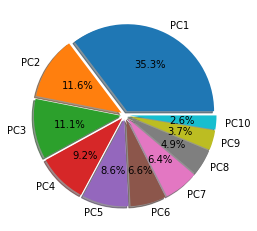

[0.35298686 0.11591127 0.11100004 0.09177928 0.08615194 0.06630303
 0.0640102  0.04890708]


0.937049695969482

In [ ]:
#Lie 0.5 data
plt.pie(lie_05_ratio, labels = labels, autopct = "%.1f%%", explode = [0.05] * 10, shadow = True)
plt.show()

#PC1 ~ PC6까지의 주성분이 전체 분산의 약 93%를 설명함.
print(lie_05_ratio[:8])
sum(lie_05_ratio[:8])

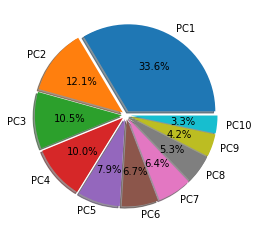

[0.33562794 0.1210865  0.10501257 0.10022196 0.07870494 0.06746066
 0.06352257 0.05313856]


0.9247757067455474

In [ ]:
#Lie 1.0 data
plt.pie(lie_10_ratio, labels = labels, autopct = "%.1f%%", explode = [0.05] * 10, shadow = True)
plt.show()

#PC1 ~ PC6까지의 주성분이 전체 분산의 약 92%를 설명함.
print(lie_10_ratio[:8])
sum(lie_10_ratio[:8])

In [ ]:
#결론
#주성분이 8개 일 때 각각의 데이터에서 누적 설명 분산량이 90% 이상이기 때문에 주성분을 8개로 결정함.
# >> Modeling 과정에서 추가 예정

In [ ]:
#PCA로 다중공선성이 해결되었는지 확인을 위한 작업 (1) - PCA 빌드
sit_pca_8 = PCA(n_components = 8)
sleep_pca_8 = PCA(n_components = 8)
lie_05_pca_8 = PCA(n_components = 8)
lie_10_pca_8 = PCA(n_components = 8)

#PCA로 다중공선성이 해결되었는지 확인을 위한 작업 (2) - transform 및 DataFrame화
pca_8_sit = sit_pca_8.fit_transform(data_sit_features)
pca_8_sleep = sleep_pca_8.fit_transform(data_sleep_features)
pca_8_lie_05 = lie_05_pca_8.fit_transform(data_lie_05_features)
pca_8_lie_10 = lie_10_pca_8.fit_transform(data_lie_10_features)

PC_labels = ["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8"]
 
sit_cor = pd.DataFrame(data = pca_8_sit, columns = PC_labels).corr()
sleep_cor = pd.DataFrame(pca_8_sleep, columns = PC_labels).corr()
lie_05_cor = pd.DataFrame(pca_8_lie_05, columns = PC_labels).corr()
lie_10_cor = pd.DataFrame(pca_8_lie_10, columns = PC_labels).corr()

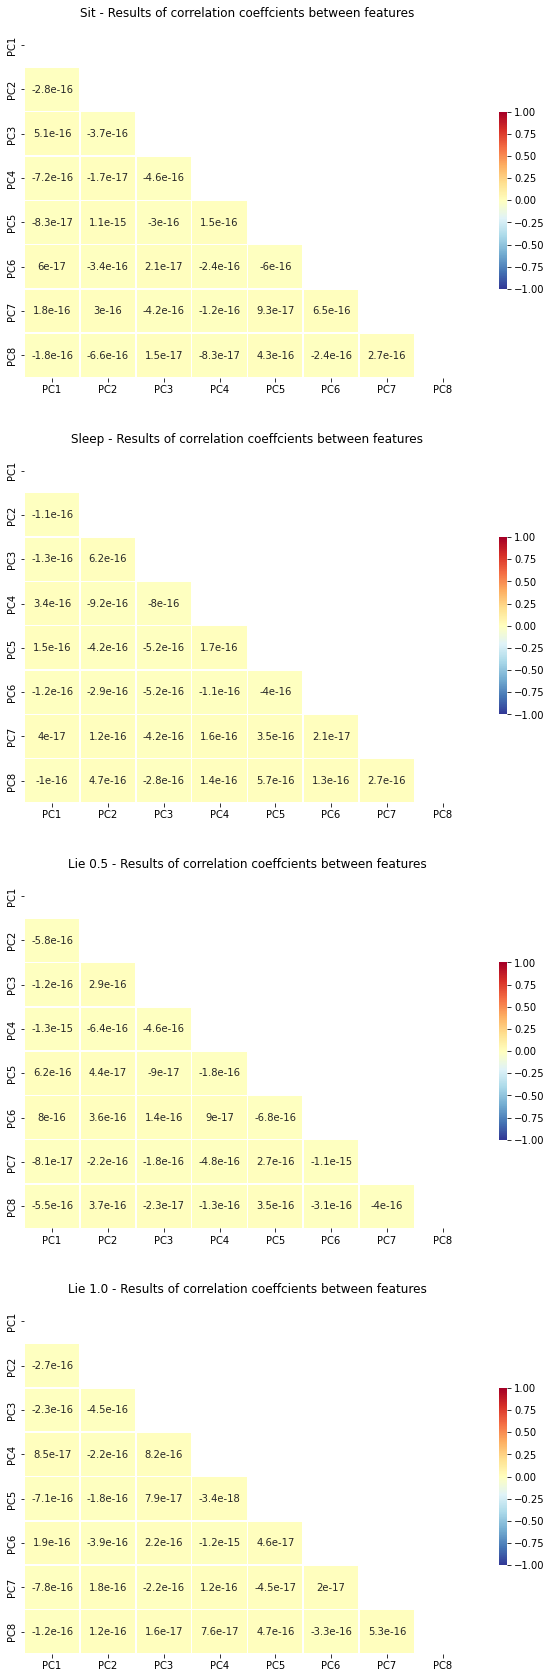

In [ ]:
#PCA로 다중공선성이 해결되었는지 확인을 위한 작업 (3) - 시각화
plt.figure(figsize=(10, 30))

#Mask
mask = np.zeros_like(sit_cor, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

#Heatmap
plt.subplot(411)
plt.title('Sit - Results of correlation coeffcients between features')
sns.heatmap(sit_cor, 
            cmap = 'RdYlBu_r', # 컬러
            annot = True,      # 값 표시
            mask=mask,         # 표시하지 않을 마스크 부분을 지정
            linewidths=.5,     # 경계면 실선
            cbar_kws={"shrink": .5},  # 컬러바 크기
            vmin = -1, vmax = 1        # 컬러바 범위 -1 ~ 1
            ) 

plt.subplot(412)
plt.title('Sleep - Results of correlation coeffcients between features')
sns.heatmap(sleep_cor, 
            cmap = 'RdYlBu_r', # 컬러
            annot = True,      # 값 표시
            mask=mask,         # 표시하지 않을 마스크 부분을 지정
            linewidths=.5,     # 경계면 실선
            cbar_kws={"shrink": .5},  # 컬러바 크기
            vmin = -1, vmax = 1        # 컬러바 범위 -1 ~ 1
            )

plt.subplot(413)
plt.title('Lie 0.5 - Results of correlation coeffcients between features')
sns.heatmap(lie_05_cor, 
            cmap = 'RdYlBu_r', # 컬러
            annot = True,      # 값 표시
            mask=mask,         # 표시하지 않을 마스크 부분을 지정
            linewidths=.5,     # 경계면 실선
            cbar_kws={"shrink": .5},  # 컬러바 크기
            vmin = -1, vmax = 1        # 컬러바 범위 -1 ~ 1
            )

plt.subplot(414)
plt.title('Lie 1.0 - Results of correlation coeffcients between features')
sns.heatmap(lie_10_cor, 
            cmap = 'RdYlBu_r', # 컬러
            annot = True,      # 값 표시
            mask=mask,         # 표시하지 않을 마스크 부분을 지정
            linewidths=.5,     # 경계면 실선
            cbar_kws={"shrink": .5},  # 컬러바 크기
            vmin = -1, vmax = 1        # 컬러바 범위 -1 ~ 1
            )

plt.show()

In [ ]:
#다중공선성이 해소 된 것을 확인할 수 있음.
#결론: Pipeline에 Modeling을 할 때 PCA 과정을 포함예정.

## 3. Modeling (1) - Dataset by posture

####Modeling 전략
1. Cover가 없는 데이터인 Sit, Sleep, Lie 0.5, Lie 1.0 각각의 데이터별로 여러 머신러닝 모델링을 해 성능이 좋은 모델을 선별한다.
2. Cover가 없는 데이터 4개를 모두 합치고 선별한 모델로 테스트 한다.
    1. 학습된 모델로 테스트
    2. 합친 데이터로 다시 재학습 후 테스트
    3. 모델 선별
3. Cover가 있는 데이터셋 4개를 선별한 모델로 테스트
    * 만약 성능이 좋다면?
        * 결론: Cover를 씌우지 않은 데이터들을 학습시킨 모델이지만 Cover를 씌운 데이터들에 대한 정확도도 높다.
    * 만약 성능이 안 좋다면?
        1. Cover씌운 데이터도 합쳐서 다시 재학습 후 테스트
        2. 모델 선별
        * 결론: 자세, 거리, cover 유무, 종류 관계없이 성능이 좋다.

### (0) 필요한 패키지, 라이브러리 import

In [ ]:
!pip install scikeras

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.10.0
    Uninstalling importlib-metadata-4.10.0:
      Successfully uninstalled importlib-metadata-4.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 3.10.1 which is incompatible.


In [ ]:
from random import randint, uniform
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split, ShuffleSplit, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from scikeras.wrappers import KerasRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import TransformedTargetRegressor
#from sklearn.kernel_ridge import KernelRidge                   #Lack of RAM
#from sklearn.gaussian_process import GaussianProcessRegressor  #Lack of RAM

### (1) 데이터 셋 나누기

In [ ]:
# Split dataset
sit_train, sit_test = train_test_split(data_sit_clean, train_size = 0.8, random_state = 2)
sleep_train, sleep_test = train_test_split(data_sleep_clean, train_size = 0.8, random_state = 2)
lie_05_train, lie_05_test = train_test_split(data_lie_05_clean, train_size = 0.8, random_state = 2)
lie_10_train, lie_10_test = train_test_split(data_lie_10_clean, train_size = 0.8, random_state = 2)

sit_train, sit_val = train_test_split(sit_train, train_size = 0.8, random_state = 2)
sleep_train, sleep_val = train_test_split(sleep_train, train_size = 0.8, random_state = 2)
lie_05_train, lie_05_val = train_test_split(lie_05_train, train_size = 0.8, random_state = 2)
lie_10_train, lie_10_val = train_test_split(lie_10_train, train_size = 0.8, random_state = 2)

In [ ]:
features = ["bin-2", "bin-1", "bin0", "bin1", "bin2", '400fft', '300fft', '200fft', '100fft', '70fft']
target = "ecg"
    #bin_var, motion_energy는 얻고자 하는 주 데이터가 아닌 비접촉 측정에 있어
    #움직임을 측정하는 보조지표라고 생각했기 때문에 features에 넣지 않았음.

#Sit data
sit_X_train = sit_train[features]
sit_y_train = sit_train[target]
sit_X_val = sit_val[features]
sit_y_val = sit_val[target]
sit_X_test = sit_test[features]
sit_y_test = sit_test[target]

#Sleep data
sleep_X_train = sleep_train[features]
sleep_y_train = sleep_train[target]
sleep_X_val = sleep_val[features]
sleep_y_val = sleep_val[target]
sleep_X_test = sleep_test[features]
sleep_y_test = sleep_test[target]

#Lie 0.5 data
lie_05_X_train = lie_05_train[features]
lie_05_y_train = lie_05_train[target]
lie_05_X_val = lie_05_val[features]
lie_05_y_val = lie_05_val[target]
lie_05_X_test = lie_05_test[features]
lie_05_y_test = lie_05_test[target]

#Lie 1.0 data
lie_10_X_train = lie_10_train[features]
lie_10_y_train = lie_10_train[target]
lie_10_X_val = lie_10_val[features]
lie_10_y_val = lie_10_val[target]
lie_10_X_test = lie_10_test[features]
lie_10_y_test = lie_10_test[target]

### (2) 모델 정의

In [ ]:
#Define Model
PCA_n_components = 8

def Linear_Regressor(**kwargs):
    return Pipeline([('scaler', StandardScaler()),
                     ('PCA', PCA(n_components = PCA_n_components)),
                     ('poly', PolynomialFeatures()),
                     ('model', LinearRegression(**kwargs))])

def Ridge_Regressor(**kwargs):
    return Pipeline([('scaler', StandardScaler()),
                     ('PCA', PCA(n_components = PCA_n_components)),
                     ('poly', PolynomialFeatures()),
                     ('model', Ridge(**kwargs))])

def PLS_Regressor(**kwargs):
    return Pipeline([('scaler', StandardScaler()),
                     ('PCA', PCA(n_components = PCA_n_components)),
                     ('model', PLSRegression(**kwargs))])

def XGB_Regressor(**kwargs):
    return Pipeline([('scaler', StandardScaler()),
                     ('PCA', PCA(n_components = PCA_n_components)),
                     ('model', XGBRegressor(**kwargs, objective='reg:squarederror'))])

def RFR_Regressor(**kwargs):
    return Pipeline([('scaler', StandardScaler()),
                     ('PCA', PCA(n_components = PCA_n_components)),
                     ('model', RandomForestRegressor(**kwargs))])
    
def ANN_Regressor():
    ann_model = keras.Sequential()
    ann_model.add(Dense(512, input_dim = PCA_n_components, kernel_initializer = "normal", activation = 'relu'))
    ann_model.add(Dense(256, activation = "relu"))
    ann_model.add(Dense(64, activation = "relu"))
    ann_model.add(Dense(32, activation = "relu"))
    ann_model.add(Dense(16, activation = "relu"))
    ann_model.add(Dense(1, activation = "linear"))
    #Compile
    ann_model.compile(loss = "mse", optimizer = "adam")
    #KerasRegressor
    kr_model = KerasRegressor(build_fn = ann_model, verbose = 0)
    #Bulid Pipeline
    ANN_model = Pipeline([("scaler", StandardScaler()),
                          ("PCA", PCA(n_components = PCA_n_components)),
                          ("model", kr_model)])
    return ANN_model

def SVR_Regressor(**kwargs):
    return Pipeline([("scaler", StandardScaler()),
                     ("PCA", PCA(n_components = PCA_n_components)),
                     ("model", SVR(**kwargs))])

def ET_Regressor(**kwargs):
    return Pipeline([("scaler", StandardScaler()),
                     ("PCA", PCA(n_components = PCA_n_components)),
                     ("model", ExtraTreesRegressor(**kwargs, random_state = 2))])

def KN_Regressor(**kwargs):
    return Pipeline([("scaler", StandardScaler()),
                     ("PCA", PCA(n_components = PCA_n_components)),
                     ("model", KNeighborsRegressor(**kwargs))])


#Parameter candidates (for GridSearchCV)
grid_params_linear = [{
    "poly__degree": np.arange(1, 4),
    "model__fit_intercept": [True, False]
    }]

grid_params_ridge = [{
    "poly__degree": np.arange(1, 4),
    "model__alpha" : np.linspace(2, 5, 5),
    "model__solver" : ["cholesky", "lsqr", "sparse_cg"],
    "model__tol" : np.logspace(-5, 0, 10)
    }]

grid_params_pls = [{
    "model__n_components" : np.arange(2, 10)
    }]

grid_params_xgb = [{
    "model__n_estimators": [100, 200, 500, 700, 1000],
    "model__max_depth": [None, 10, 20, 30, 50],
    "model__learning_rate": [0.01, 0.03, 0.07, 0.1]
    }]

grid_params_rfr = [{
    "model__n_estimators": [100, 200, 500, 700, 1000],
    "model__max_depth": [None, 10, 20, 30, 50, 70]
    }]

grid_params_ann = [{
    "model__batch_size": [10, 30, 50, 100, 200],
    "model__epochs": [10, 20, 50, 100],
    "model__optimizer": ["adam", "rmsprop"]
    }]

grid_params_svr = [{
    "model__kernel": ["rbf", "linear"],
    "model__degree": [2, 3, 5],
    "model__gamma": np.logspace(-5, 1, 10)
    }]

grid_params_et = [{
    "model__n_estimators": [100, 200, 500],
    "model__max_depth": [None, 10, 20, 30, 50]
    }]

grid_params_kn = [{
    "model__n_neighbors" : [1, 2, 4, 7, 9],
    "model__weights" : ["uniform", "distance"],
    "model__algorithm" : ["ball_tree", "kd_tree", "brute"]
    }]

params = [grid_params_linear,
          grid_params_ridge,
          grid_params_pls,
          grid_params_xgb,
          grid_params_rfr,
          grid_params_ann,
          grid_params_svr,
          grid_params_et,
          grid_params_kn]

grid_dict = {
    0: "BaseLine(Linear)",
    1: "Ridge",
    2: "PLS",
    3: "XGBoost",
    4: "RandomForestRegressor",
    5: "ANN",
    6: "Support Vector Machine Regressor",
    7: "Extra trees",
    8: "KNN"
    }

#GridSearchCV - cv value
cv = ShuffleSplit(n_splits = 3 , test_size = 0.3, random_state = 2)

### (3.1) Sit Data

In [ ]:
#Model
sit_linear_model = Linear_Regressor()
sit_ridge_model = Ridge_Regressor()
sit_pls_model = PLS_Regressor()
sit_xgb_model = XGB_Regressor()
sit_rfr_model = RFR_Regressor()
sit_ann_model = ANN_Regressor()
sit_svr_model = SVR_Regressor()
sit_et_model = ET_Regressor()
sit_kn_model = KN_Regressor()

pipe = [sit_linear_model,
        sit_ridge_model,
        sit_pls_model,
        sit_xgb_model,
        sit_rfr_model,
        sit_ann_model,
        sit_svr_model,
        sit_et_model,
        sit_kn_model]

model_mse = {}
model_r2 = {}
model_best_params = {}

In [ ]:
for idx , (param , model) in enumerate(zip(params , pipe)) :

    search = GridSearchCV(model, param , scoring = "neg_mean_squared_error", 
                          cv = cv , n_jobs = -1 , verbose = 1)
    
    search.fit(sit_X_train , sit_y_train)

    y_pred = search.predict(sit_X_val)
    model_mse[grid_dict.get(idx)] = mean_squared_error(sit_y_val, y_pred) 
    model_r2[grid_dict.get(idx)] = r2_score(sit_y_val, y_pred)  
    model_best_params[grid_dict.get(idx)] = search.best_params_

print("finish")

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 450 candidates, totalling 1350 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 150 candidates, totalling 450 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


INFO:tensorflow:Assets written to: ram:///tmp/tmpz6x3qobx/assets
Fitting 3 folds for each of 40 candidates, totalling 120 fits
INFO:tensorflow:Assets written to: ram:///tmp/tmp1mseu8ud/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpjf8yfnv8/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpc22lr4ga/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp6_rz1t8n/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpjhpgoj4v/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp9ao9ua0x/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmppiwccyal/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpxl037rt9/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp1s5e7sii/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp5vq9663n/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpvqstzqpa/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmphg7ex5rf/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpf6fjvz_n/assets
INFO:tensorflow:Assets writt

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


INFO:tensorflow:Assets written to: ram:///tmp/tmp7f0w1g46/assets


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


INFO:tensorflow:Assets written to: ram:///tmp/tmp7of_o5o6/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpeyyj114i/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpidnuhhqz/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpymy9li3b/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpzp0ey9fo/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpe98a31j3/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpsonjvh1g/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpp2ypy7c1/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpynmjp97_/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp8hnqbh6s/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpgrad_v98/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpye7snhym/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp1yw1hqb9/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpu_4j9_h1/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpolotyo4t/assets
INFO:tensorflow:Assets wr

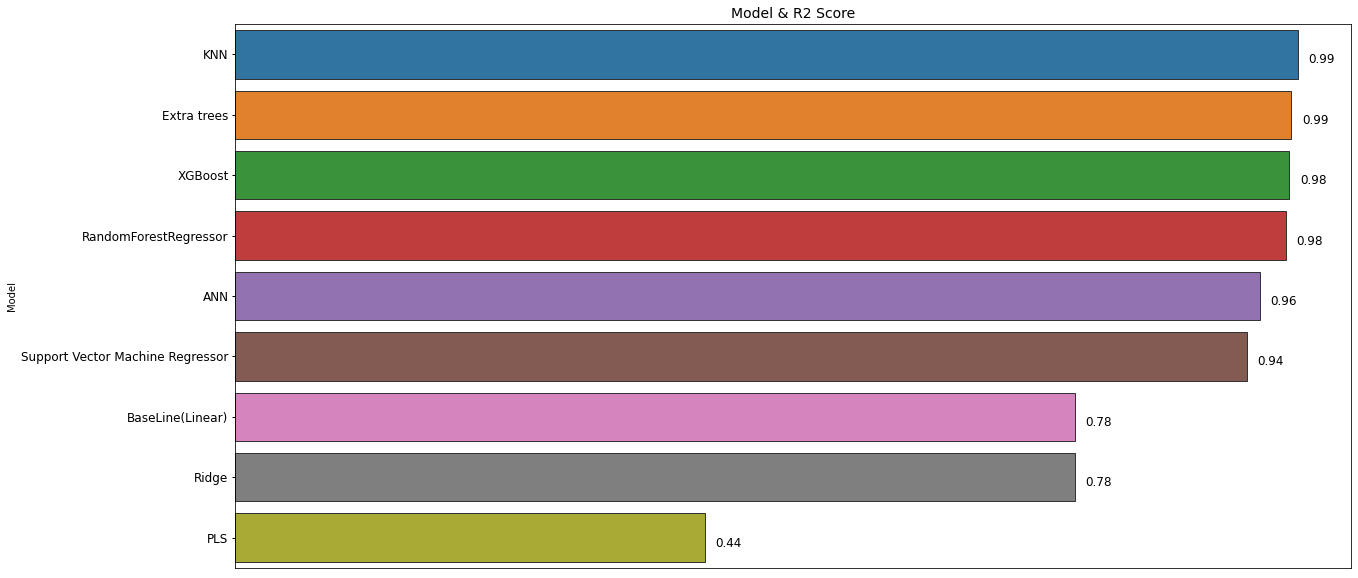

In [ ]:
output = pd.DataFrame([model_r2.keys() , model_r2.values()], index = ["Model","r2"]).T
output.sort_values(["r2"], ascending= False ,inplace=True)

fig ,ax = plt.subplots(figsize=(20, 10))
sns.barplot(y="Model", x="r2", data = output, ax = ax, edgecolor = ".2")
for i in ax.patches:
    ax.text(i.get_width()+.01, i.get_y()+.55, \
        str(round((i.get_width()), 2)), fontsize=12, color='black')

kwargs= {'length':3, 'width':1, 'colors':'black','labelsize':'large'}
ax.tick_params(**kwargs)
x_axis = ax.axes.get_xaxis().set_visible(False)
ax.set_title("Model & R2 Score", fontsize = 14)
plt.show()

In [ ]:
model_mse , model_r2
model_best_params

{'ANN': {'model__batch_size': 10,
  'model__epochs': 100,
  'model__optimizer': 'adam'},
 'BaseLine(Linear)': {'model__fit_intercept': False, 'poly__degree': 3},
 'Extra trees': {'model__max_depth': 70,
  'model__max_features': 'log2',
  'model__n_estimators': 1000},
 'KNN': {'model__algorithm': 'brute',
  'model__n_neighbors': 4,
  'model__weights': 'distance'},
 'PLS': {'model__n_components': 2},
 'RandomForestRegressor': {'model__max_depth': 50,
  'model__max_features': 'log2',
  'model__n_estimators': 1000},
 'Ridge': {'model__alpha': 5.0,
  'model__solver': 'lsqr',
  'model__tol': 3.5938136638046256e-05,
  'poly__degree': 3},
 'Support Vector Machine Regressor': {'model__degree': 2,
  'model__gamma': 0.46415888336127725,
  'model__kernel': 'rbf'},
 'XGBoost': {'model__learning_rate': 0.01,
  'model__max_depth': 30,
  'model__n_estimators': 1000}}

### (3.2) Sleep Data

In [ ]:
#Model
sleep_linear_model = Linear_Regressor()
sleep_ridge_model = Ridge_Regressor()
sleep_pls_model = PLS_Regressor()
sleep_xgb_model = XGB_Regressor()
sleep_rfr_model = RFR_Regressor()
sleep_ann_model = ANN_Regressor()
sleep_svr_model = SVR_Regressor()
sleep_et_model = ET_Regressor()
sleep_kn_model = KN_Regressor()

pipe = [sleep_linear_model,
        sleep_ridge_model,
        sleep_pls_model,
        sleep_xgb_model,
        sleep_rfr_model,
        sleep_ann_model,
        sleep_svr_model,
        sleep_et_model,
        sleep_kn_model]

model_mse = {}
model_r2 = {}
model_best_params = {}

In [ ]:
for idx , (param , model) in enumerate(zip(params , pipe)) :

    search = GridSearchCV(model, param , scoring = "neg_mean_squared_error", 
                          cv = cv , n_jobs = -1 , verbose = 1)
    
    search.fit(sleep_X_train , sleep_y_train)

    y_pred = search.predict(sleep_X_val)
    model_mse[grid_dict.get(idx)] = mean_squared_error(sleep_y_val, y_pred) 
    model_r2[grid_dict.get(idx)] = r2_score(sleep_y_val, y_pred)  
    model_best_params[grid_dict.get(idx)] = search.best_params_

print("finish")

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 450 candidates, totalling 1350 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
INFO:tensorflow:Assets written to: ram:///tmp/tmpkqwa7egl/assets
Fitting 3 folds for each of 40 candidates, totalling 120 fits
INFO:tensorflow:Assets written to: ram:///tmp/tmp37xw2m7v/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp1rcipv5v/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpuu9_s0lk/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp1ns315m8/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp7ggocwds/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp7u437_oq/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpc4ckz2v_/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpot8d3nyi/assets
INFO:tensorflow:Assets written to: ram:///tm

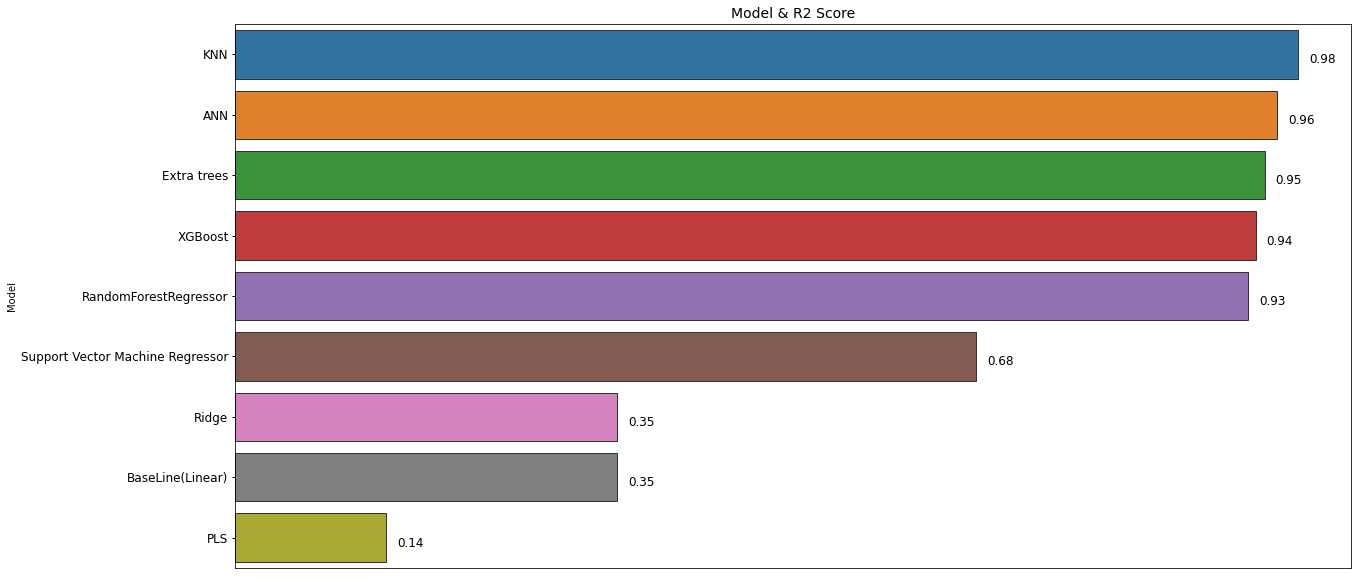

In [ ]:
output = pd.DataFrame([model_r2.keys() , model_r2.values()], index = ["Model","r2"]).T
output.sort_values(["r2"], ascending= False ,inplace=True)

fig ,ax = plt.subplots(figsize=(20, 10))
sns.barplot(y="Model", x="r2", data = output, ax = ax, edgecolor = ".2")
for i in ax.patches:
    ax.text(i.get_width()+.01, i.get_y()+.55, \
        str(round((i.get_width()), 2)), fontsize=12, color='black')

kwargs= {'length':3, 'width':1, 'colors':'black','labelsize':'large'}
ax.tick_params(**kwargs)
x_axis = ax.axes.get_xaxis().set_visible(False)
ax.set_title("Model & R2 Score", fontsize = 14)
plt.show()

In [ ]:
model_mse , model_r2
model_best_params

{'ANN': {'model__batch_size': 10,
  'model__epochs': 100,
  'model__optimizer': 'adam'},
 'BaseLine(Linear)': {'model__fit_intercept': True, 'poly__degree': 3},
 'Extra trees': {'model__max_depth': 50,
  'model__max_features': 'log2',
  'model__n_estimators': 700},
 'KNN': {'model__algorithm': 'ball_tree',
  'model__n_neighbors': 2,
  'model__weights': 'distance'},
 'PLS': {'model__n_components': 8},
 'RandomForestRegressor': {'model__max_depth': 30,
  'model__max_features': 'log2',
  'model__n_estimators': 1000},
 'Ridge': {'model__alpha': 5.0,
  'model__solver': 'sparse_cg',
  'model__tol': 0.0004641588833612782,
  'poly__degree': 3},
 'Support Vector Machine Regressor': {'model__degree': 2,
  'model__gamma': 0.46415888336127725,
  'model__kernel': 'rbf'},
 'XGBoost': {'model__learning_rate': 0.1,
  'model__max_depth': 50,
  'model__n_estimators': 200}}

### (3.3) Lie 0.5 Data

In [ ]:
#Model
lie_05_linear_model = Linear_Regressor()
lie_05_ridge_model = Ridge_Regressor()
lie_05_pls_model = PLS_Regressor()
lie_05_xgb_model = XGB_Regressor()
lie_05_rfr_model = RFR_Regressor()
lie_05_ann_model = ANN_Regressor()
lie_05_svr_model = SVR_Regressor()
lie_05_et_model = ET_Regressor()
lie_05_kn_model = KN_Regressor()

pipe = [lie_05_linear_model,
        lie_05_ridge_model,
        lie_05_pls_model,
        lie_05_xgb_model,
        lie_05_rfr_model,
        lie_05_ann_model,
        lie_05_svr_model,
        lie_05_et_model,
        lie_05_kn_model]

model_mse = {}
model_r2 = {}
model_best_params = {}

In [ ]:
for idx , (param , model) in enumerate(zip(params , pipe)) :

    search = GridSearchCV(model, param , scoring = "neg_mean_squared_error", 
                          cv = cv , n_jobs = -1 , verbose = 1)
    
    search.fit(lie_05_X_train , lie_05_y_train)

    y_pred = search.predict(lie_05_X_val)
    model_mse[grid_dict.get(idx)] = mean_squared_error(lie_05_y_val, y_pred) 
    model_r2[grid_dict.get(idx)] = r2_score(lie_05_y_val, y_pred)  
    model_best_params[grid_dict.get(idx)] = search.best_params_

print("finish")

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 450 candidates, totalling 1350 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
INFO:tensorflow:Assets written to: ram:///tmp/tmp0rghyu5j/assets
Fitting 3 folds for each of 40 candidates, totalling 120 fits
INFO:tensorflow:Assets written to: ram:///tmp/tmpu1mv0b0_/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpkbnoqza5/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpewz_569q/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp4jhdf4d1/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp2oi3tmwu/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp64lh8oo_/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpr4zix62u/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp1jx2p5og/assets
INFO:tensorflow:Assets written to: ram:///tm

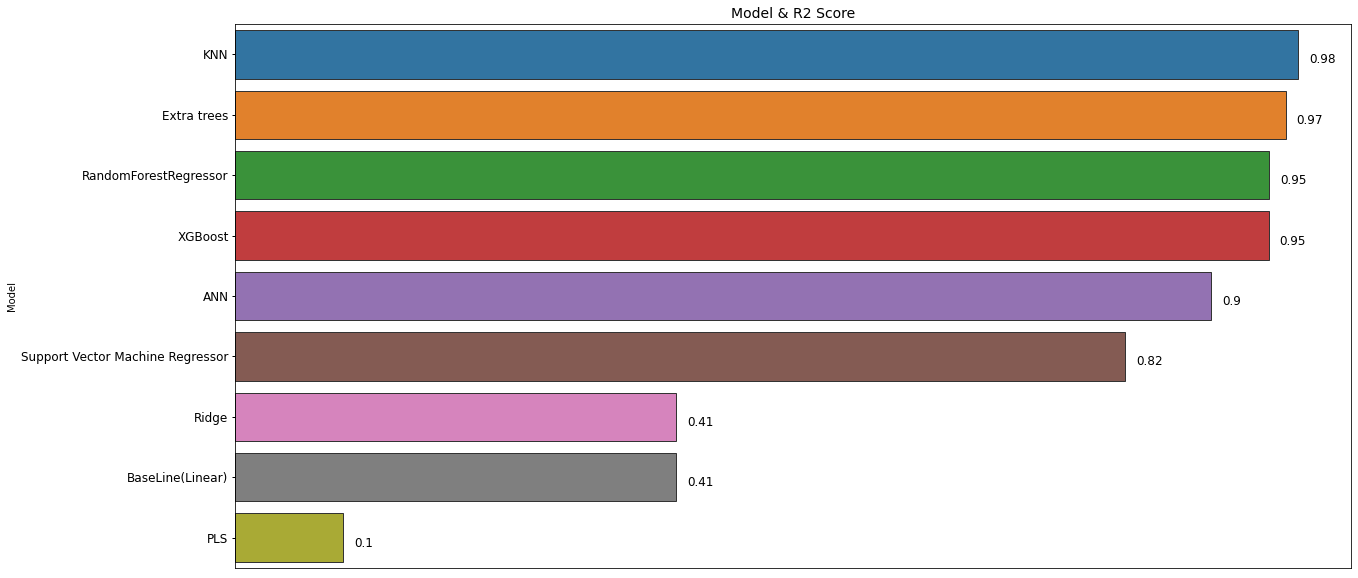

In [ ]:
output = pd.DataFrame([model_r2.keys() , model_r2.values()], index = ["Model","r2"]).T
output.sort_values(["r2"], ascending= False ,inplace=True)

fig ,ax = plt.subplots(figsize=(20, 10))
sns.barplot(y="Model", x="r2", data = output, ax = ax, edgecolor = ".2")
for i in ax.patches:
    ax.text(i.get_width()+.01, i.get_y()+.55, \
        str(round((i.get_width()), 2)), fontsize=12, color='black')

kwargs= {'length':3, 'width':1, 'colors':'black','labelsize':'large'}
ax.tick_params(**kwargs)
x_axis = ax.axes.get_xaxis().set_visible(False)
ax.set_title("Model & R2 Score", fontsize = 14)
plt.show()

In [ ]:
model_mse , model_r2
model_best_params

{'ANN': {'model__batch_size': 10,
  'model__epochs': 100,
  'model__optimizer': 'rmsprop'},
 'BaseLine(Linear)': {'model__fit_intercept': True, 'poly__degree': 3},
 'Extra trees': {'model__max_depth': 50,
  'model__max_features': 'log2',
  'model__n_estimators': 700},
 'KNN': {'model__algorithm': 'brute',
  'model__n_neighbors': 2,
  'model__weights': 'distance'},
 'PLS': {'model__n_components': 2},
 'RandomForestRegressor': {'model__max_depth': 70,
  'model__max_features': 'log2',
  'model__n_estimators': 1000},
 'Ridge': {'model__alpha': 5.0,
  'model__solver': 'lsqr',
  'model__tol': 3.5938136638046256e-05,
  'poly__degree': 3},
 'Support Vector Machine Regressor': {'model__degree': 2,
  'model__gamma': 2.154434690031882,
  'model__kernel': 'rbf'},
 'XGBoost': {'model__learning_rate': 0.03,
  'model__max_depth': 70,
  'model__n_estimators': 700}}

### (3.4) Lie 1.0 Data

In [ ]:
#Model
lie_10_linear_model = Linear_Regressor()
lie_10_ridge_model = Ridge_Regressor()
lie_10_pls_model = PLS_Regressor()
lie_10_xgb_model = XGB_Regressor()
lie_10_rfr_model = RFR_Regressor()
lie_10_ann_model = ANN_Regressor()
lie_10_svr_model = SVR_Regressor()
lie_10_et_model = ET_Regressor()
lie_10_kn_model = KN_Regressor()

pipe = [lie_10_linear_model,
        lie_10_ridge_model,
        lie_10_pls_model,
        lie_10_xgb_model,
        lie_10_rfr_model,
        lie_10_ann_model,
        lie_10_svr_model,
        lie_10_et_model,
        lie_10_kn_model]

model_mse = {}
model_r2 = {}
model_best_params = {}

In [ ]:
for idx , (param , model) in enumerate(zip(params , pipe)) :

    search = GridSearchCV(model, param , scoring = "neg_mean_squared_error", 
                          cv = cv , n_jobs = -1 , verbose = 1)
    
    search.fit(lie_10_X_train , lie_10_y_train)

    y_pred = search.predict(lie_10_X_val)
    model_mse[grid_dict.get(idx)] = mean_squared_error(lie_10_y_val, y_pred) 
    model_r2[grid_dict.get(idx)] = r2_score(lie_10_y_val, y_pred)  
    model_best_params[grid_dict.get(idx)] = search.best_params_

print("finish")

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 450 candidates, totalling 1350 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 150 candidates, totalling 450 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


INFO:tensorflow:Assets written to: ram:///tmp/tmpldewnqo2/assets
Fitting 3 folds for each of 40 candidates, totalling 120 fits
INFO:tensorflow:Assets written to: ram:///tmp/tmpyz5q8ig1/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpq5qpkshh/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpfndwo5q4/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpeqzjipep/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp5myt8ql5/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpxfrr73ch/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpnoxrbnb7/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp2rx_83r0/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpg2_dlvkx/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpw5n99i0b/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp9dg7q6rb/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpig6iecz1/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmprmbsp149/assets
INFO:tensorflow:Assets writt

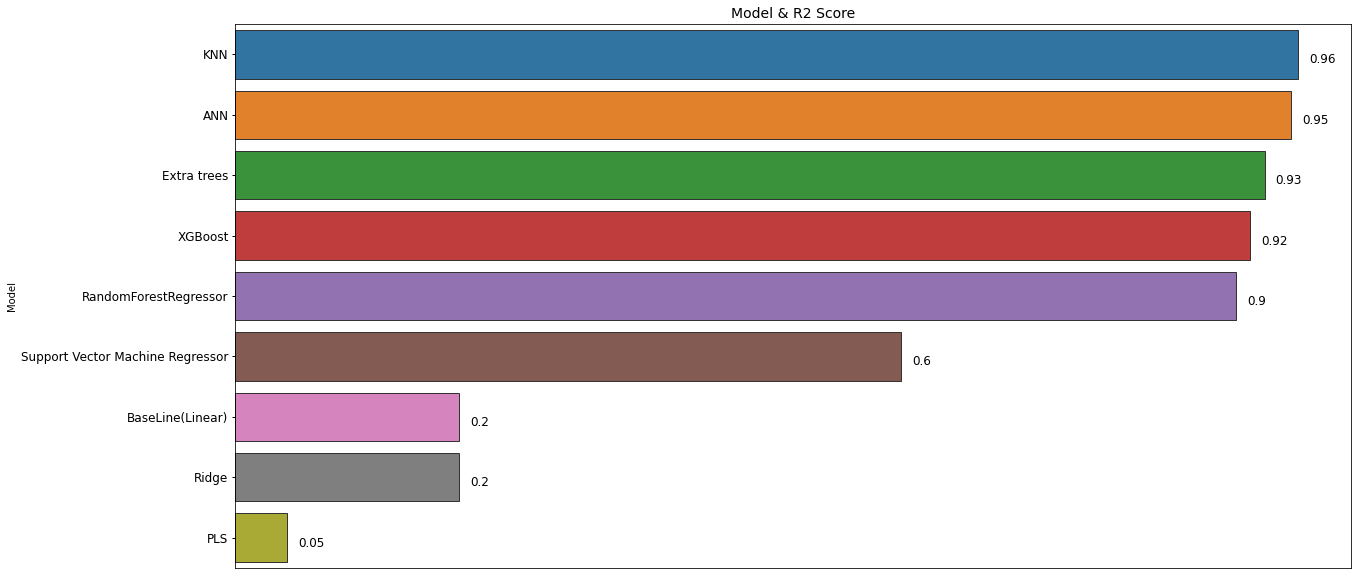

In [ ]:
output = pd.DataFrame([model_r2.keys() , model_r2.values()], index = ["Model","r2"]).T
output.sort_values(["r2"], ascending= False ,inplace=True)

fig ,ax = plt.subplots(figsize=(20, 10))
sns.barplot(y="Model", x="r2", data = output, ax = ax, edgecolor = ".2")
for i in ax.patches:
    ax.text(i.get_width()+.01, i.get_y()+.55, \
        str(round((i.get_width()), 2)), fontsize=12, color='black')

kwargs= {'length':3, 'width':1, 'colors':'black','labelsize':'large'}
ax.tick_params(**kwargs)
x_axis = ax.axes.get_xaxis().set_visible(False)
ax.set_title("Model & R2 Score", fontsize = 14)
plt.show()

In [ ]:
model_mse , model_r2
model_best_params

{'ANN': {'model__batch_size': 30,
  'model__epochs': 100,
  'model__optimizer': 'adam'},
 'BaseLine(Linear)': {'model__fit_intercept': False, 'poly__degree': 3},
 'Extra trees': {'model__max_depth': 70,
  'model__max_features': 'log2',
  'model__n_estimators': 700},
 'KNN': {'model__algorithm': 'brute',
  'model__n_neighbors': 2,
  'model__weights': 'distance'},
 'PLS': {'model__n_components': 2},
 'RandomForestRegressor': {'model__max_depth': 50,
  'model__max_features': 'log2',
  'model__n_estimators': 700},
 'Ridge': {'model__alpha': 5.0,
  'model__solver': 'lsqr',
  'model__tol': 1e-05,
  'poly__degree': 3},
 'Support Vector Machine Regressor': {'model__degree': 2,
  'model__gamma': 2.154434690031882,
  'model__kernel': 'rbf'},
 'XGBoost': {'model__learning_rate': 0.01,
  'model__max_depth': 30,
  'model__n_estimators': 1000}}

## 4. Modeling (2) - Merged dataset without cover 

### (1) 데이터셋 준비

In [ ]:
#Cover가 없는 데이터셋 4개 합치기
non_cover_merged_X_train = pd.concat([sit_X_train, sleep_X_train, lie_05_X_train, lie_10_X_train])
non_cover_merged_X_val = pd.concat([sit_X_val, sleep_X_val, lie_05_X_val, lie_10_X_val])
non_cover_merged_X_test = pd.concat([sit_X_test, sleep_X_test, lie_05_X_test, lie_10_X_test])

non_cover_merged_y_train = pd.concat([sit_y_train, sleep_y_train, lie_05_y_train, lie_10_y_train])
non_cover_merged_y_val = pd.concat([sit_y_val, sleep_y_val, lie_05_y_val, lie_10_y_val])
non_cover_merged_y_test = pd.concat([sit_y_test, sleep_y_test, lie_05_y_test, lie_10_y_test])

#확인
print(non_cover_merged_X_train.shape)
print(non_cover_merged_X_val.shape)
print(non_cover_merged_X_test.shape)
print(non_cover_merged_y_train.shape)
print(non_cover_merged_y_val.shape)
print(non_cover_merged_y_test.shape)

(90190, 10)
(22549, 10)
(28187, 10)
(90190,)
(22549,)
(28187,)


In [ ]:
for_predict_X_list = [non_cover_merged_X_test, sit_X_test, sleep_X_test, lie_05_X_test, lie_10_X_test]
for_predict_y_list = [non_cover_merged_y_test, sit_y_test, sleep_y_test, lie_05_y_test, lie_10_y_test]
data_name = ["Non cover merged data", "Sit data", "Sleep data", "Lie 0.5 data", "Lie 1.0 data"]

### (2) 필요한 함수 정의

In [ ]:
def evaluate_model(model, X_data_list, y_data_list, data_name, log_transform = False):
    for i in range(len(data_name)):
        y_pred = model.predict(X_data_list[i])

        if log_transform == True:
            y_pred = np.expm1(y_pred)

        r2 = r2_score(y_data_list[i], y_pred)
        mse = mean_squared_error(y_data_list[i], y_pred)

        print(f"===={data_name[i]}====")
        print("R squared: ", r2)
        print("MSE: ", mse)
        print()

### (3.1) KNN

In [ ]:
non_cover_merged_kn_model = KN_Regressor()

knn_search = GridSearchCV(non_cover_merged_kn_model, grid_params_kn, scoring = "neg_mean_squared_error",
                      cv = cv, n_jobs = -1, verbose = 1)

knn_search.fit(non_cover_merged_X_train, non_cover_merged_y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=2, test_size=0.3, train_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('PCA', PCA(n_components=8)),
                                       ('model', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid=[{'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'model__n_neighbors': [1, 2, 4, 7, 9],
                          'model__weights': ['uniform', 'distance']}],
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
print(knn_search.best_params_)

{'model__algorithm': 'kd_tree', 'model__n_neighbors': 2, 'model__weights': 'distance'}


In [ ]:
evaluate_model(knn_search, for_predict_X_list, for_predict_y_list, data_name = data_name)

====Non cover merged data====
R squared:  0.9667391142314623
MSE:  7.493104319686094

====Sit data====
R squared:  0.6590508751524146
MSE:  7.422148541658839

====Sleep data====
R squared:  0.8545325517375455
MSE:  5.0852288862465755

====Lie 0.5 data====
R squared:  0.4619338075727163
MSE:  11.266977650954454

====Lie 1.0 data====
R squared:  0.831000799310111
MSE:  7.448513088093846



### (3.2) Extra trees

In [ ]:
non_cover_merged_et_model = ET_Regressor()

et_search = GridSearchCV(non_cover_merged_et_model, grid_params_et, scoring = "neg_mean_squared_error",
                      cv = cv, n_jobs = -1, verbose = 1)

et_search.fit(non_cover_merged_X_train, non_cover_merged_y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=2, test_size=0.3, train_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('PCA', PCA(n_components=8)),
                                       ('model',
                                        ExtraTreesRegressor(random_state=2))]),
             n_jobs=-1,
             param_grid=[{'model__max_depth': [None, 10, 20, 30, 50],
                          'model__n_estimators': [100, 200, 500]}],
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
print(et_search.best_params_)

{'model__max_depth': None, 'model__n_estimators': 500}


In [ ]:
evaluate_model(et_search, for_predict_X_list, for_predict_y_list, data_name = data_name)

====Non cover merged data====
R squared:  0.9617403585160808
MSE:  8.619237829919067

====Sit data====
R squared:  0.51111288427435
MSE:  10.642622398989937

====Sleep data====
R squared:  0.8837796456089779
MSE:  4.062813436121708

====Lie 0.5 data====
R squared:  0.29249071721315556
MSE:  14.815075522663484

====Lie 1.0 data====
R squared:  0.8147206313142495
MSE:  8.166049288848168



### (3.3) RandomForest

In [ ]:
non_cover_merged_rfr_model = RFR_Regressor()

rfr_search = GridSearchCV(non_cover_merged_rfr_model, grid_params_rfr, scoring = "neg_mean_squared_error",
                      cv = cv, n_jobs = -1, verbose = 1)

rfr_search.fit(non_cover_merged_X_train, non_cover_merged_y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=2, test_size=0.3, train_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('PCA', PCA(n_components=8)),
                                       ('model', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid=[{'model__max_depth': [None, 10, 20, 30, 50, 70],
                          'model__n_estimators': [100, 200, 500, 700, 1000]}],
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
print(rfr_search.best_params_)

{'model__max_depth': 50, 'model__n_estimators': 1000}


In [ ]:
evaluate_model(rfr_search, for_predict_X_list, for_predict_y_list, data_name = data_name)

====Non cover merged data====
R squared:  0.9518551093377854
MSE:  10.846214099718946

====Sit data====
R squared:  0.37035538844685445
MSE:  13.706783490034294

====Sleep data====
R squared:  0.8455534973411525
MSE:  5.399117301373892

====Lie 0.5 data====
R squared:  0.11987261296786578
MSE:  18.42965742736965

====Lie 1.0 data====
R squared:  0.7708327073318321
MSE:  10.100376639852396



### (3.4) XGBoost

In [ ]:
non_cover_merged_xgb_model = XGB_Regressor()

xgb_search = GridSearchCV(non_cover_merged_xgb_model, grid_params_xgb, scoring = "neg_mean_squared_error",
                      cv = cv, n_jobs = -1, verbose = 1)

xgb_search.fit(non_cover_merged_X_train, non_cover_merged_y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-pac

GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=2, test_size=0.3, train_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('PCA', PCA(n_components=8)),
                                       ('model',
                                        XGBRegressor(objective='reg:squarederror'))]),
             n_jobs=-1,
             param_grid=[{'model__learning_rate': [0.01, 0.03, 0.07, 0.1],
                          'model__max_depth': [None, 10, 20, 30, 50],
                          'model__n_estimators': [100, 200, 500, 700, 1000]}],
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
print(xgb_search.best_params_)

{'model__learning_rate': 0.07, 'model__max_depth': 50, 'model__n_estimators': 500}


In [ ]:
evaluate_model(xgb_search, for_predict_X_list, for_predict_y_list, data_name = data_name)

====Non cover merged data====
R squared:  0.9552603898082488
MSE:  10.079063098974759

====Sit data====
R squared:  0.4397508453453097
MSE:  12.196108284615104

====Sleep data====
R squared:  0.8213787716981651
MSE:  6.2442136760281475

====Lie 0.5 data====
R squared:  0.1508399856673861
MSE:  17.78120803392179

====Lie 1.0 data====
R squared:  0.8026183662928092
MSE:  8.69944754777361



### (3.5) ANN

In [ ]:
non_cover_merged_ann_model = ANN_Regressor()

ann_search = GridSearchCV(non_cover_merged_ann_model, grid_params_ann, scoring = "neg_mean_squared_error",
                      cv = cv, n_jobs = -1, verbose = 1)

ann_search.fit(non_cover_merged_X_train, non_cover_merged_y_train)

INFO:tensorflow:Assets written to: ram:///tmp/tmpco12v6ku/assets
Fitting 3 folds for each of 40 candidates, totalling 120 fits
INFO:tensorflow:Assets written to: ram:///tmp/tmpwnfp1iwo/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpeap7ldae/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpjsm3mx3d/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpqr7912ul/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpcvyhew35/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpfr3w9vkk/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmppqygryej/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpfvigfbjs/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpkwsa7hz4/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpn1hv9m8k/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp0hqr5tva/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpsj_yc3eu/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpwah_j1oc/assets
INFO:tensorflow:Assets writt

GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=2, test_size=0.3, train_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('PCA', PCA(n_components=8)),
                                       ('model',
                                        KerasRegressor(build_fn=<keras.engine.sequential.Sequential object at 0x7efb4c12f510>, verbose=0))]),
             n_jobs=-1,
             param_grid=[{'model__batch_size': [10, 30, 50, 100, 200],
                          'model__epochs': [10, 20, 50, 100],
                          'model__optimizer': ['adam', 'rmsprop']}],
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
print(ann_search.best_params_)

{'model__batch_size': 10, 'model__epochs': 100, 'model__optimizer': 'adam'}


In [ ]:
evaluate_model(ann_search, for_predict_X_list, for_predict_y_list, data_name = data_name)

====Non cover merged data====
R squared:  0.9566967741952457
MSE:  9.755470452349646

====Sit data====
R squared:  0.6170851571001887
MSE:  8.335703586506753

====Sleep data====
R squared:  0.7360069660530218
MSE:  9.228628246595422

====Lie 0.5 data====
R squared:  0.22891728599427918
MSE:  16.146287999526862

====Lie 1.0 data====
R squared:  0.8124577063716468
MSE:  8.265786009397988



### (4) Re-define Model

1. 성능이 좋지 않아 PCA의 n_components을 8에서 default값 (None)으로 변경  
    * 데이터 반영율 90% >> 100%

2. Log-transformation
    * Target 값들에 log를 씌워 데이터 분포를 정규분포화



In [ ]:
#Re-define Model
PCA_n_components = None

def RFR_Regressor(**kwargs):
    return Pipeline([('scaler', StandardScaler()),
                     ('PCA', PCA(n_components = PCA_n_components)),
                     ('model', RandomForestRegressor(**kwargs))])

def ET_Regressor(**kwargs):
    return Pipeline([("scaler", StandardScaler()),
                     ("PCA", PCA(n_components = PCA_n_components)),
                     ("model", ExtraTreesRegressor(**kwargs, random_state = 2))])

def KN_Regressor(**kwargs):
    return Pipeline([("scaler", StandardScaler()),
                     ("PCA", PCA(n_components = PCA_n_components)),
                     ("model", KNeighborsRegressor(**kwargs))])


#Parameter candidates (for GridSearchCV)
grid_params_rfr = [{
    "model__n_estimators": [100, 200, 500, 700, 1000],
    "model__max_depth": [None, 10, 20, 30, 50, 70]
    }]

grid_params_et = [{
    "model__n_estimators": [100, 200, 500],
    "model__max_depth": [None, 10, 20, 30, 50]
    }]

grid_params_kn = [{
    "model__n_neighbors" : [1, 2, 4, 7, 9],
    "model__weights" : ["uniform", "distance"],
    "model__algorithm" : ["ball_tree", "kd_tree", "brute"]
    }]

In [ ]:
#Cover 씌운 데이터들에 대해서도 예측 성능 비교를 위한 작업
lie_10_acryl_X = data_lie_10_acryl_clean[features]
lie_10_opaque_X = data_lie_10_opaque_clean[features]
lie_10_gmk_X = data_lie_10_gmk_clean[features]
lie_10_acryl111_X = data_lie_10_acryl111_clean[features]

lie_10_acryl_y = data_lie_10_acryl_clean[target]
lie_10_opaque_y = data_lie_10_opaque_clean[target]
lie_10_gmk_y = data_lie_10_gmk_clean[target]
lie_10_acryl111_y = data_lie_10_acryl111_clean[target]

for_predict_X_list = [non_cover_merged_X_test, sit_X_test,
                      sleep_X_test, lie_05_X_test, lie_10_X_test,
                      lie_10_acryl_X, lie_10_opaque_X, lie_10_gmk_X, lie_10_acryl111_X]

for_predict_y_list = [non_cover_merged_y_test, sit_y_test,
                      sleep_y_test, lie_05_y_test, lie_10_y_test,
                      lie_10_acryl_y, lie_10_opaque_y, lie_10_gmk_y, lie_10_acryl111_y]

data_name = ["Non cover merged data", "Sit data", "Sleep data", "Lie 0.5 data", "Lie 1.0 data",
             "Lie 1.0 Acryl data", "Lie 1.0 Opaque data", "Lie 1.0 Gmk data", "Lie 1.0 Acryl111 data"]

### (5.1) KNN

In [ ]:
non_cover_merged_kn_model = KN_Regressor()

knn_search = GridSearchCV(non_cover_merged_kn_model, grid_params_kn, scoring = "neg_mean_squared_error",
                      cv = cv, n_jobs = -1, verbose = 1)

log_trans_knn_search = TransformedTargetRegressor(regressor = knn_search, func = np.log1p, inverse_func = np.expm1)

log_trans_knn_search.fit(non_cover_merged_X_train, non_cover_merged_y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=2, test_size=0.3, train_size=None),
                                                  estimator=Pipeline(steps=[('scaler',
                                                                             StandardScaler()),
                                                                            ('PCA',
                                                                             PCA()),
                                                                            ('model',
                                                                             KNeighborsRegressor())]),
                                                  n_jobs=-1,
                                                  param_grid=[{'model__algorithm': ['ball_tree',
                                                                                    'kd_tree',


In [ ]:
print(log_trans_knn_search.regressor_.best_params_)

{'model__algorithm': 'brute', 'model__n_neighbors': 2, 'model__weights': 'distance'}


In [ ]:
evaluate_model(log_trans_knn_search, for_predict_X_list, for_predict_y_list, data_name = data_name)

====Non cover merged data====
R squared:  0.9754557706720712
MSE:  5.5293918532511395

====Sit data====
R squared:  0.7893291238560873
MSE:  4.586111012428969

====Sleep data====
R squared:  0.8809648976273131
MSE:  4.161210967080256

====Lie 0.5 data====
R squared:  0.5685898538338041
MSE:  9.033625497491956

====Lie 1.0 data====
R squared:  0.879218508000627
MSE:  5.323353721699921

====Lie 1.0 Acryl data====
R squared:  -4.855360661364478
MSE:  220.64995793492892

====Lie 1.0 Opaque data====
R squared:  -6.193193614118282
MSE:  210.81741712491157

====Lie 1.0 Gmk data====
R squared:  -3.2001978759635206
MSE:  311.57062792502273

====Lie 1.0 Acryl111 data====
R squared:  -26.4571851429994
MSE:  459.7614683748183



### (5.2) Extra trees

In [ ]:
non_cover_merged_et_model = ET_Regressor()

et_search = GridSearchCV(non_cover_merged_et_model, grid_params_et, scoring = "neg_mean_squared_error",
                      cv = cv, n_jobs = -1, verbose = 1)

log_trans_et_search = TransformedTargetRegressor(regressor = et_search, func = np.log1p, inverse_func = np.expm1)

log_trans_et_search.fit(non_cover_merged_X_train, non_cover_merged_y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=2, test_size=0.3, train_size=None),
                                                  estimator=Pipeline(steps=[('scaler',
                                                                             StandardScaler()),
                                                                            ('PCA',
                                                                             PCA()),
                                                                            ('model',
                                                                             ExtraTreesRegressor(random_state=2))]),
                                                  n_jobs=-1,
                                                  param_grid=[{'model__max_depth': [None,
                                                                                    10,


In [ ]:
print(log_trans_et_search.regressor_.best_params_)

{'model__max_depth': None, 'model__n_estimators': 500}


In [ ]:
evaluate_model(log_trans_et_search, for_predict_X_list, for_predict_y_list, data_name = data_name)

====Non cover merged data====
R squared:  0.9660624680265242
MSE:  7.645541047811878

====Sit data====
R squared:  0.4791688277844618
MSE:  11.338015098405368

====Sleep data====
R squared:  0.893831032375595
MSE:  3.7114385894259843

====Lie 0.5 data====
R squared:  0.24905120312169038
MSE:  15.72468858017407

====Lie 1.0 data====
R squared:  0.8711940493427062
MSE:  5.677025721889251

====Lie 1.0 Acryl data====
R squared:  -1.6619203017244604
MSE:  100.31023476951194

====Lie 1.0 Opaque data====
R squared:  -1.548770074735986
MSE:  74.69910485190964

====Lie 1.0 Gmk data====
R squared:  -1.5351280322270848
MSE:  188.05576694172402

====Lie 1.0 Acryl111 data====
R squared:  -18.13642210156073
MSE:  320.4330479993544



### (5.3) RandomForest

In [ ]:
non_cover_merged_rfr_model = RFR_Regressor()

rfr_search = GridSearchCV(non_cover_merged_rfr_model, grid_params_et, scoring = "neg_mean_squared_error",
                      cv = cv, n_jobs = -1, verbose = 1)

log_trans_rfr_search = TransformedTargetRegressor(regressor = rfr_search, func = np.log1p, inverse_func = np.expm1)

log_trans_rfr_search.fit(non_cover_merged_X_train, non_cover_merged_y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=2, test_size=0.3, train_size=None),
                                                  estimator=Pipeline(steps=[('scaler',
                                                                             StandardScaler()),
                                                                            ('PCA',
                                                                             PCA()),
                                                                            ('model',
                                                                             RandomForestRegressor())]),
                                                  n_jobs=-1,
                                                  param_grid=[{'model__max_depth': [None,
                                                                                    10,
            

In [ ]:
print(log_trans_rfr_search.regressor_.best_params_)

{'model__max_depth': 50, 'model__n_estimators': 500}


In [ ]:
evaluate_model(log_trans_rfr_search, for_predict_X_list, for_predict_y_list, data_name = data_name)

====Non cover merged data====
R squared:  0.9564916516931492
MSE:  9.801681016831326

====Sit data====
R squared:  0.32976147305111925
MSE:  14.590475654046637

====Sleep data====
R squared:  0.8564422534281053
MSE:  5.018469825597986

====Lie 0.5 data====
R squared:  0.08664242904785291
MSE:  19.12548954771698

====Lie 1.0 data====
R squared:  0.8301737214046397
MSE:  7.484965926797387

====Lie 1.0 Acryl data====
R squared:  -2.1236723237365935
MSE:  117.71062564647683

====Lie 1.0 Opaque data====
R squared:  -2.0757262029876156
MSE:  90.14308368185657

====Lie 1.0 Gmk data====
R squared:  -1.7153699929379527
MSE:  201.42611341956464

====Lie 1.0 Acryl111 data====
R squared:  -21.45458467889108
MSE:  375.99458101574



### (6.0) Delete PCA process modeling

1. 그래도 성능이 좋지 않아 PCA 과정 생략하였음.
    - **일부 features들 다중공선성 높지만 왜 PCA 안 해도 되는지 근거 찾아야 함.**
    - 개념, 이론적으로 접근해봐야 할 것 같음.
    - 관련 링크: https://m.blog.naver.com/tjgml1343/222078517673

In [ ]:
#Re-define Model
def RFR_Regressor(**kwargs):
    return Pipeline([('scaler', StandardScaler()),
                     ('model', RandomForestRegressor(**kwargs))])

def ET_Regressor(**kwargs):
    return Pipeline([("scaler", StandardScaler()),
                     ("model", ExtraTreesRegressor(**kwargs, random_state = 2))])

def KN_Regressor(**kwargs):
    return Pipeline([("scaler", StandardScaler()),
                     ("model", KNeighborsRegressor(**kwargs))])

#Parameter candidates (for GridSearchCV)
grid_params_rfr = [{
    "model__n_estimators": [100, 200, 500, 700, 1000],
    "model__max_depth": [None, 10, 20, 30, 50, 70]
    }]

grid_params_et = [{
    "model__n_estimators": [100, 200, 500],
    "model__max_depth": [None, 10, 20, 30, 50]
    }]

grid_params_kn = [{
    "model__n_neighbors" : [1, 2, 4, 7, 9],
    "model__weights" : ["uniform", "distance"],
    "model__algorithm" : ["ball_tree", "kd_tree", "brute"]
    }]

### (6.1) KNN

In [ ]:
non_cover_merged_kn_model = KN_Regressor()

knn_search = GridSearchCV(non_cover_merged_kn_model, grid_params_kn, scoring = "neg_mean_squared_error",
                      cv = cv, n_jobs = -1, verbose = 1)

log_trans_knn_search = TransformedTargetRegressor(regressor = knn_search, func = np.log1p, inverse_func = np.expm1)

log_trans_knn_search.fit(non_cover_merged_X_train, non_cover_merged_y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=2, test_size=0.3, train_size=None),
                                                  estimator=Pipeline(steps=[('scaler',
                                                                             StandardScaler()),
                                                                            ('model',
                                                                             KNeighborsRegressor())]),
                                                  n_jobs=-1,
                                                  param_grid=[{'model__algorithm': ['ball_tree',
                                                                                    'kd_tree',
                                                                                    'brute'],
                                                               'model__n_ne

In [ ]:
print(log_trans_knn_search.regressor_.best_params_)

{'model__algorithm': 'brute', 'model__n_neighbors': 2, 'model__weights': 'distance'}


In [ ]:
evaluate_model(log_trans_knn_search, for_predict_X_list, for_predict_y_list, data_name = data_name)

====Non cover merged data====
R squared:  0.975455232425655
MSE:  5.529513110892165

====Sit data====
R squared:  0.7893276199906079
MSE:  4.586143750195875

====Sleep data====
R squared:  0.8809540069476887
MSE:  4.161591681798765

====Lie 0.5 data====
R squared:  0.568609641714111
MSE:  9.033211144001038

====Lie 1.0 data====
R squared:  0.8792139258414978
MSE:  5.323555676928735

====Lie 1.0 Acryl data====
R squared:  -4.855325710417285
MSE:  220.64864086404742

====Lie 1.0 Opaque data====
R squared:  -6.193181768103331
MSE:  210.81706994306032

====Lie 1.0 Gmk data====
R squared:  -3.200216783214577
MSE:  311.57203046467873

====Lie 1.0 Acryl111 data====
R squared:  -26.457857085951606
MSE:  459.77271983693146



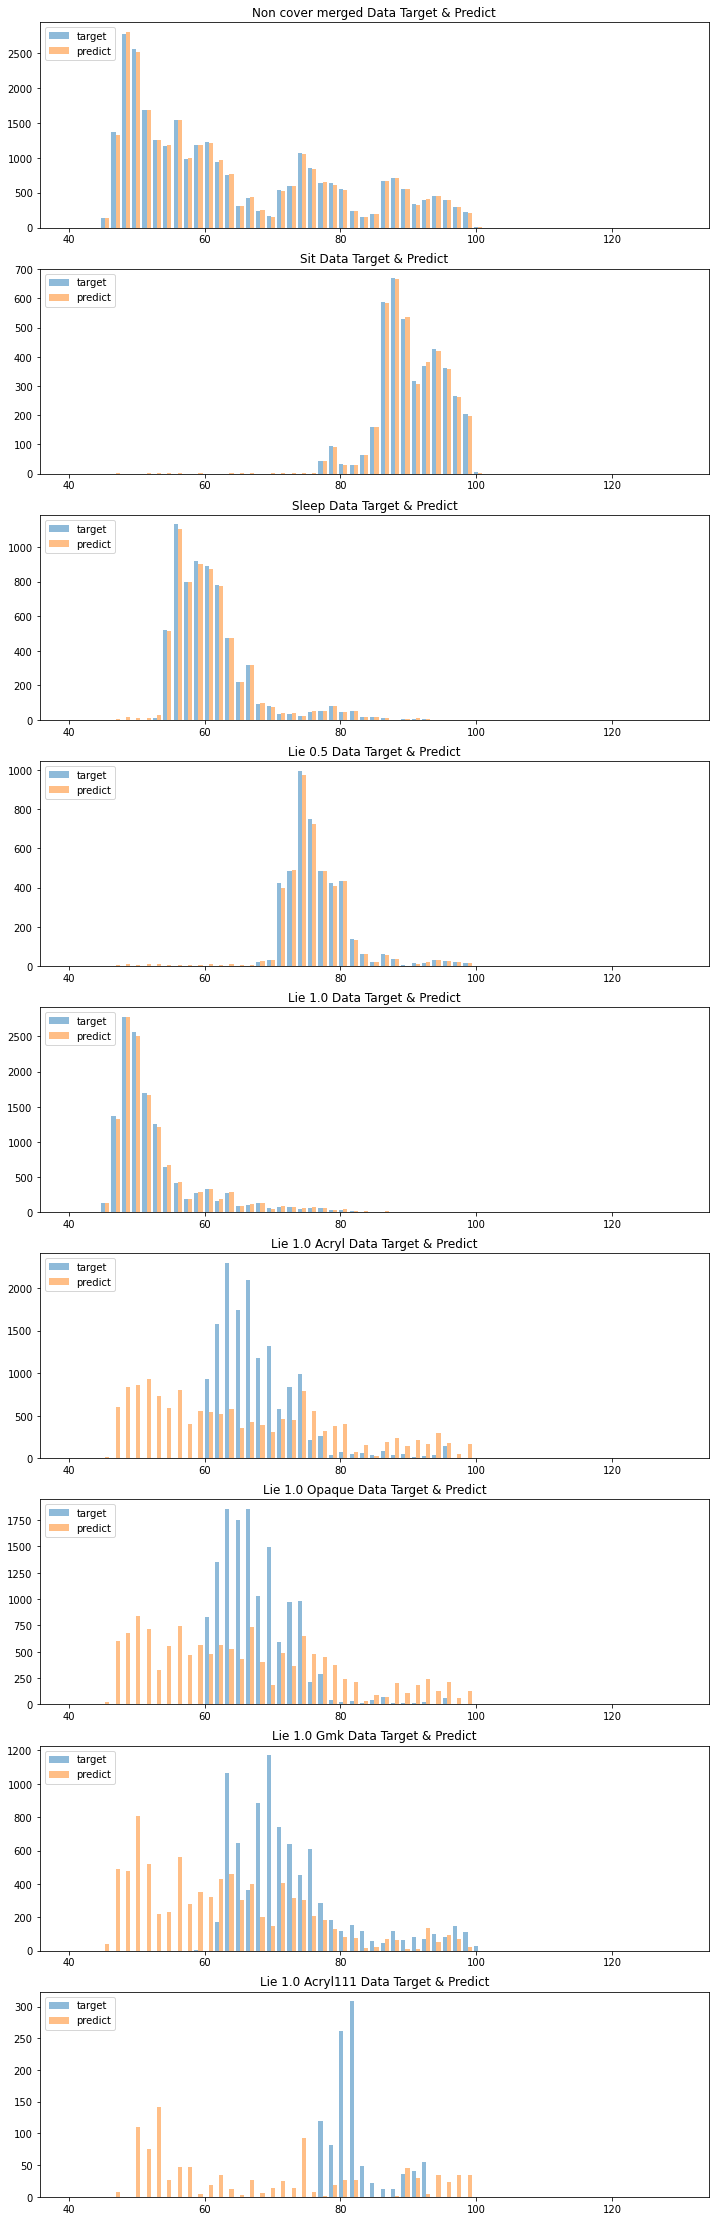

In [ ]:
# 타겟값 예측값 히스토그램
log_trans_knn_predict_non_cover_merged_test = log_trans_knn_search.predict(non_cover_merged_X_test)
log_trans_knn_predict_sit_test = log_trans_knn_search.predict(sit_X_test)
log_trans_knn_predict_sleep_test = log_trans_knn_search.predict(sleep_X_test)
log_trans_knn_predict_lie_05_test = log_trans_knn_search.predict(lie_05_X_test)
log_trans_knn_predict_lie_10_test = log_trans_knn_search.predict(lie_10_X_test)
log_trans_knn_predict_lie_10_acryl = log_trans_knn_search.predict(lie_10_acryl_X)
log_trans_knn_predict_lie_10_opaque = log_trans_knn_search.predict(lie_10_opaque_X)
log_trans_knn_predict_lie_10_gmk = log_trans_knn_search.predict(lie_10_gmk_X)
log_trans_knn_predict_lie_10_acryl111 = log_trans_knn_search.predict(lie_10_acryl111_X)

bins = np.linspace(40, 130, 60)
plt.figure(figsize=(12, 40))

plt.subplot(911)
plt.title('Non cover merged Data Target & Predict')
plt.hist([non_cover_merged_y_test, log_trans_knn_predict_non_cover_merged_test], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(912)
plt.title('Sit Data Target & Predict')
plt.hist([sit_y_test, log_trans_knn_predict_sit_test], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(913)
plt.title('Sleep Data Target & Predict')
plt.hist([sleep_y_test, log_trans_knn_predict_sleep_test], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(914)
plt.title('Lie 0.5 Data Target & Predict')
plt.hist([lie_05_y_test, log_trans_knn_predict_lie_05_test], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(915)
plt.title('Lie 1.0 Data Target & Predict')
plt.hist([lie_10_y_test, log_trans_knn_predict_lie_10_test], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(916)
plt.title('Lie 1.0 Acryl Data Target & Predict')
plt.hist([lie_10_acryl_y, log_trans_knn_predict_lie_10_acryl], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(917)
plt.title('Lie 1.0 Opaque Data Target & Predict')
plt.hist([lie_10_opaque_y, log_trans_knn_predict_lie_10_opaque], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(918)
plt.title('Lie 1.0 Gmk Data Target & Predict')
plt.hist([lie_10_gmk_y, log_trans_knn_predict_lie_10_gmk], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(919)
plt.title('Lie 1.0 Acryl111 Data Target & Predict')
plt.hist([lie_10_acryl111_y, log_trans_knn_predict_lie_10_acryl111], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.show()

### (6.2) Extra trees

In [ ]:
non_cover_merged_et_model = ET_Regressor()

et_search = GridSearchCV(non_cover_merged_et_model, grid_params_et, scoring = "neg_mean_squared_error",
                      cv = cv, n_jobs = -1, verbose = 1)

log_trans_et_search = TransformedTargetRegressor(regressor = et_search, func = np.log1p, inverse_func = np.expm1)

log_trans_et_search.fit(non_cover_merged_X_train, non_cover_merged_y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=2, test_size=0.3, train_size=None),
                                                  estimator=Pipeline(steps=[('scaler',
                                                                             StandardScaler()),
                                                                            ('model',
                                                                             ExtraTreesRegressor(random_state=2))]),
                                                  n_jobs=-1,
                                                  param_grid=[{'model__max_depth': [None,
                                                                                    10,
                                                                                    20,
                                                                                 

In [ ]:
print(log_trans_et_search.regressor_.best_params_)

{'model__max_depth': 50, 'model__n_estimators': 500}


In [ ]:
evaluate_model(log_trans_et_search, for_predict_X_list, for_predict_y_list, data_name = data_name)

====Non cover merged data====
R squared:  0.9941734237846691
MSE:  1.3126272015694396

====Sit data====
R squared:  0.9078338898997098
MSE:  2.006371361055809

====Sleep data====
R squared:  0.9779709919753535
MSE:  0.7700867051725356

====Lie 0.5 data====
R squared:  0.873481354547021
MSE:  2.649270240000054

====Lie 1.0 data====
R squared:  0.9794843355842926
MSE:  0.9042125305180831

====Lie 1.0 Acryl data====
R squared:  -1.5654703662776566
MSE:  96.67567228396139

====Lie 1.0 Opaque data====
R squared:  -1.4397109020055923
MSE:  71.50280925051291

====Lie 1.0 Gmk data====
R squared:  -1.5236603666117134
MSE:  187.20509564429238

====Lie 1.0 Acryl111 data====
R squared:  -22.056028360145756
MSE:  386.06555619394067



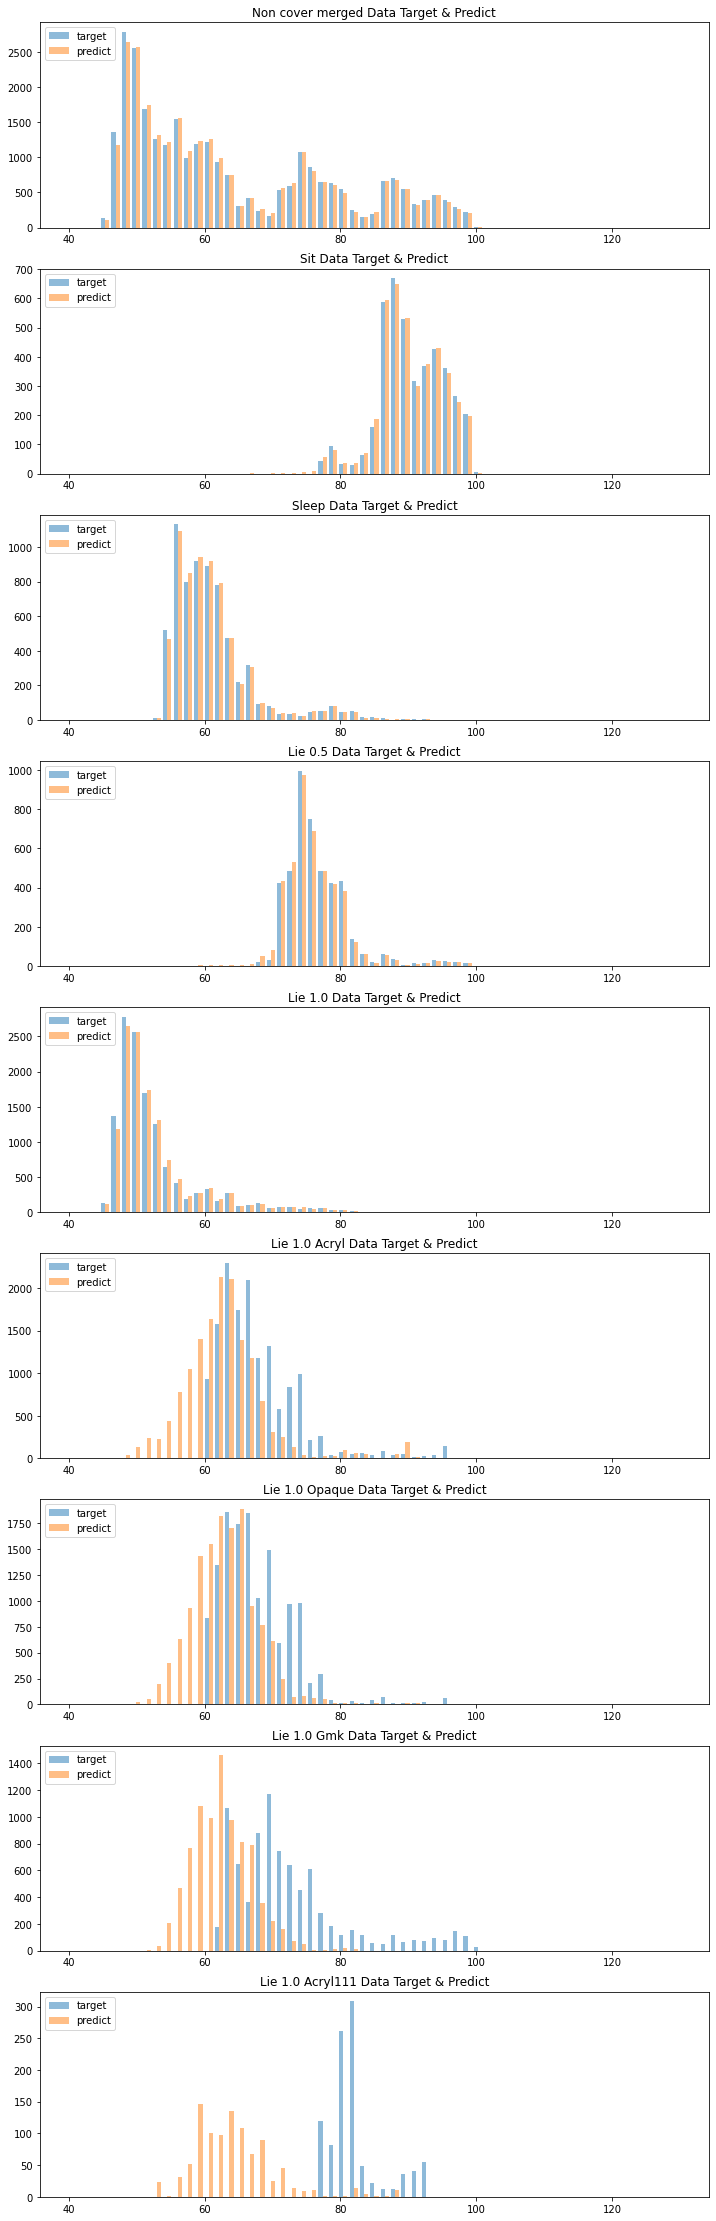

In [ ]:
# 타겟값 예측값 히스토그램
log_trans_et_predict_non_cover_merged_test = log_trans_et_search.predict(non_cover_merged_X_test)
log_trans_et_predict_sit_test = log_trans_et_search.predict(sit_X_test)
log_trans_et_predict_sleep_test = log_trans_et_search.predict(sleep_X_test)
log_trans_et_predict_lie_05_test = log_trans_et_search.predict(lie_05_X_test)
log_trans_et_predict_lie_10_test = log_trans_et_search.predict(lie_10_X_test)
log_trans_et_predict_lie_10_acryl = log_trans_et_search.predict(lie_10_acryl_X)
log_trans_et_predict_lie_10_opaque = log_trans_et_search.predict(lie_10_opaque_X)
log_trans_et_predict_lie_10_gmk = log_trans_et_search.predict(lie_10_gmk_X)
log_trans_et_predict_lie_10_acryl111 = log_trans_et_search.predict(lie_10_acryl111_X)

bins = np.linspace(40, 130, 60)
plt.figure(figsize=(12, 40))

plt.subplot(911)
plt.title('Non cover merged Data Target & Predict')
plt.hist([non_cover_merged_y_test, log_trans_et_predict_non_cover_merged_test], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(912)
plt.title('Sit Data Target & Predict')
plt.hist([sit_y_test, log_trans_et_predict_sit_test], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(913)
plt.title('Sleep Data Target & Predict')
plt.hist([sleep_y_test, log_trans_et_predict_sleep_test], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(914)
plt.title('Lie 0.5 Data Target & Predict')
plt.hist([lie_05_y_test, log_trans_et_predict_lie_05_test], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(915)
plt.title('Lie 1.0 Data Target & Predict')
plt.hist([lie_10_y_test, log_trans_et_predict_lie_10_test], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(916)
plt.title('Lie 1.0 Acryl Data Target & Predict')
plt.hist([lie_10_acryl_y, log_trans_et_predict_lie_10_acryl], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(917)
plt.title('Lie 1.0 Opaque Data Target & Predict')
plt.hist([lie_10_opaque_y, log_trans_et_predict_lie_10_opaque], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(918)
plt.title('Lie 1.0 Gmk Data Target & Predict')
plt.hist([lie_10_gmk_y, log_trans_et_predict_lie_10_gmk], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(919)
plt.title('Lie 1.0 Acryl111 Data Target & Predict')
plt.hist([lie_10_acryl111_y, log_trans_et_predict_lie_10_acryl111], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.show()

### (6.3) RandomForest

In [ ]:
non_cover_merged_rfr_model = RFR_Regressor()

rfr_search = GridSearchCV(non_cover_merged_rfr_model, grid_params_et, scoring = "neg_mean_squared_error",
                      cv = cv, n_jobs = -1, verbose = 1)

log_trans_rfr_search = TransformedTargetRegressor(regressor = rfr_search, func = np.log1p, inverse_func = np.expm1)

log_trans_rfr_search.fit(non_cover_merged_X_train, non_cover_merged_y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=2, test_size=0.3, train_size=None),
                                                  estimator=Pipeline(steps=[('scaler',
                                                                             StandardScaler()),
                                                                            ('model',
                                                                             RandomForestRegressor())]),
                                                  n_jobs=-1,
                                                  param_grid=[{'model__max_depth': [None,
                                                                                    10,
                                                                                    20,
                                                                                    30,
     

In [ ]:
print(log_trans_rfr_search.regressor_.best_params_)

{'model__max_depth': 50, 'model__n_estimators': 500}


In [ ]:
evaluate_model(log_trans_rfr_search, for_predict_X_list, for_predict_y_list, data_name = data_name)

====Non cover merged data====
R squared:  0.9905406967523656
MSE:  2.131017992705323

====Sit data====
R squared:  0.8377879535927741
MSE:  3.5312069043118797

====Sleep data====
R squared:  0.964321115638074
MSE:  1.2472570018480655

====Lie 0.5 data====
R squared:  0.8078062880329961
MSE:  4.024490458353517

====Lie 1.0 data====
R squared:  0.9664870132153686
MSE:  1.4770597710961706

====Lie 1.0 Acryl data====
R squared:  -2.1075748347002046
MSE:  117.1040173632034

====Lie 1.0 Opaque data====
R squared:  -2.1929147499331756
MSE:  93.57763419015852

====Lie 1.0 Gmk data====
R squared:  -1.8690910818307684
MSE:  212.8291419448971

====Lie 1.0 Acryl111 data====
R squared:  -21.35885916206457
MSE:  374.3916889513174



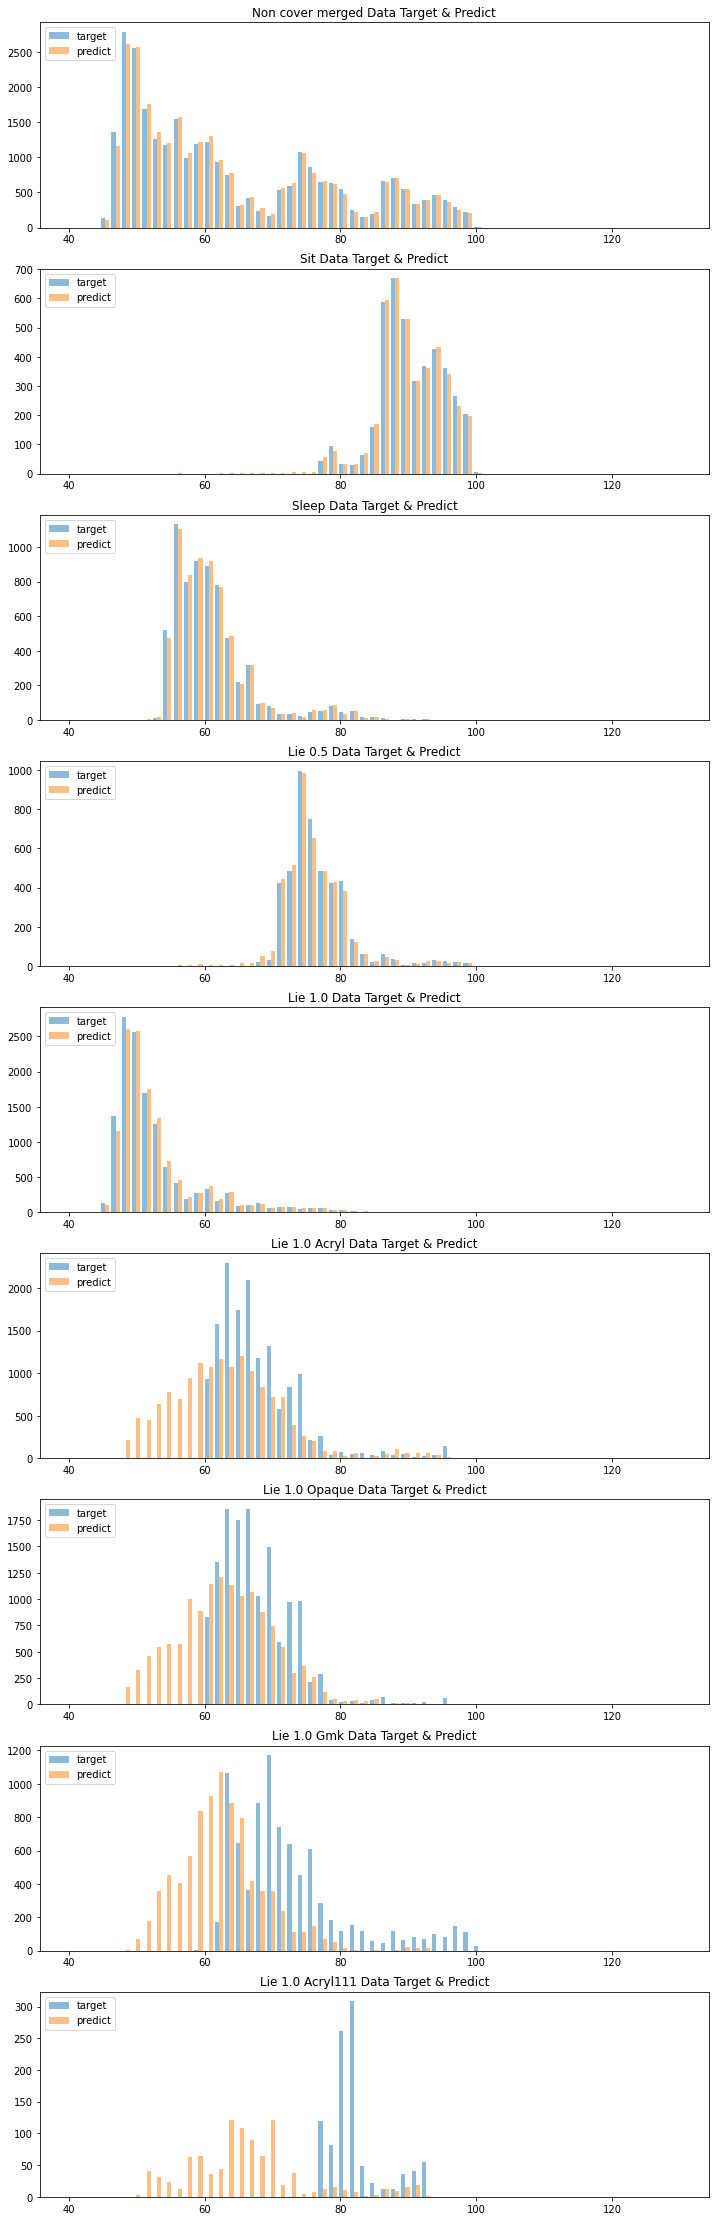

In [ ]:
# 타겟값 예측값 히스토그램
log_trans_rfr_predict_non_cover_merged_test = log_trans_rfr_search.predict(non_cover_merged_X_test)
log_trans_rfr_predict_sit_test = log_trans_rfr_search.predict(sit_X_test)
log_trans_rfr_predict_sleep_test = log_trans_rfr_search.predict(sleep_X_test)
log_trans_rfr_predict_lie_05_test = log_trans_rfr_search.predict(lie_05_X_test)
log_trans_rfr_predict_lie_10_test = log_trans_rfr_search.predict(lie_10_X_test)
log_trans_rfr_predict_lie_10_acryl = log_trans_rfr_search.predict(lie_10_acryl_X)
log_trans_rfr_predict_lie_10_opaque = log_trans_rfr_search.predict(lie_10_opaque_X)
log_trans_rfr_predict_lie_10_gmk = log_trans_rfr_search.predict(lie_10_gmk_X)
log_trans_rfr_predict_lie_10_acryl111 = log_trans_rfr_search.predict(lie_10_acryl111_X)

bins = np.linspace(40, 130, 60)
plt.figure(figsize=(12, 40))

plt.subplot(911)
plt.title('Non cover merged Data Target & Predict')
plt.hist([non_cover_merged_y_test, log_trans_rfr_predict_non_cover_merged_test], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(912)
plt.title('Sit Data Target & Predict')
plt.hist([sit_y_test, log_trans_rfr_predict_sit_test], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(913)
plt.title('Sleep Data Target & Predict')
plt.hist([sleep_y_test, log_trans_rfr_predict_sleep_test], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(914)
plt.title('Lie 0.5 Data Target & Predict')
plt.hist([lie_05_y_test, log_trans_rfr_predict_lie_05_test], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(915)
plt.title('Lie 1.0 Data Target & Predict')
plt.hist([lie_10_y_test, log_trans_rfr_predict_lie_10_test], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(916)
plt.title('Lie 1.0 Acryl Data Target & Predict')
plt.hist([lie_10_acryl_y, log_trans_rfr_predict_lie_10_acryl], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(917)
plt.title('Lie 1.0 Opaque Data Target & Predict')
plt.hist([lie_10_opaque_y, log_trans_rfr_predict_lie_10_opaque], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(918)
plt.title('Lie 1.0 Gmk Data Target & Predict')
plt.hist([lie_10_gmk_y, log_trans_rfr_predict_lie_10_gmk], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(919)
plt.title('Lie 1.0 Acryl111 Data Target & Predict')
plt.hist([lie_10_acryl111_y, log_trans_rfr_predict_lie_10_acryl111], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.show()

## 5. Modeling (3) - All-inclusive dataset

### (1) 데이터셋 준비

In [ ]:
#Split
lie_10_acryl_train, lie_10_acryl_test = train_test_split(data_lie_10_acryl_clean, train_size = 0.8, random_state = 2)
lie_10_acryl_train, lie_10_acryl_val = train_test_split(lie_10_acryl_train, train_size = 0.8, random_state = 2)

lie_10_opaque_train, lie_10_opaque_test = train_test_split(data_lie_10_opaque_clean, train_size = 0.8, random_state = 2)
lie_10_opaque_train, lie_10_opaque_val = train_test_split(lie_10_opaque_train, train_size = 0.8, random_state = 2)

lie_10_gmk_train, lie_10_gmk_test = train_test_split(data_lie_10_gmk_clean, train_size = 0.8, random_state = 2)
lie_10_gmk_train, lie_10_gmk_val = train_test_split(lie_10_gmk_train, train_size = 0.8, random_state = 2)

lie_10_acryl111_train, lie_10_acryl111_test = train_test_split(data_lie_10_acryl111_clean, train_size = 0.8, random_state = 2)
lie_10_acryl111_train, lie_10_acryl111_val = train_test_split(lie_10_acryl111_train, train_size = 0.8, random_state = 2)

#Lie 1.0 Acryl data
lie_10_acryl_X_train = lie_10_acryl_train[features]
lie_10_acryl_y_train = lie_10_acryl_train[target]
lie_10_acryl_X_val = lie_10_acryl_val[features]
lie_10_acryl_y_val = lie_10_acryl_val[target]
lie_10_acryl_X_test = lie_10_acryl_test[features]
lie_10_acryl_y_test = lie_10_acryl_test[target]

#Lie 1.0 Opaque data
lie_10_opaque_X_train = lie_10_opaque_train[features]
lie_10_opaque_y_train = lie_10_opaque_train[target]
lie_10_opaque_X_val = lie_10_opaque_val[features]
lie_10_opaque_y_val = lie_10_opaque_val[target]
lie_10_opaque_X_test = lie_10_opaque_test[features]
lie_10_opaque_y_test = lie_10_opaque_test[target]

#Lie 1.0 Gmk data
lie_10_gmk_X_train = lie_10_gmk_train[features]
lie_10_gmk_y_train = lie_10_gmk_train[target]
lie_10_gmk_X_val = lie_10_gmk_val[features]
lie_10_gmk_y_val = lie_10_gmk_val[target]
lie_10_gmk_X_test = lie_10_gmk_test[features]
lie_10_gmk_y_test = lie_10_gmk_test[target]

#Lie 1.0 Acryl111 data
lie_10_acryl111_X_train = lie_10_acryl111_train[features]
lie_10_acryl111_y_train = lie_10_acryl111_train[target]
lie_10_acryl111_X_val = lie_10_acryl111_val[features]
lie_10_acryl111_y_val = lie_10_acryl111_val[target]
lie_10_acryl111_X_test = lie_10_acryl111_test[features]
lie_10_acryl111_y_test = lie_10_acryl111_test[target]

In [ ]:
#모든 데이터셋 합치기
merged_X_train = pd.concat([non_cover_merged_X_train,
                         lie_10_acryl_X_train, lie_10_opaque_X_train,
                         lie_10_gmk_X_train, lie_10_acryl111_X_train])

merged_X_val = pd.concat([non_cover_merged_X_val,
                         lie_10_acryl_X_val, lie_10_opaque_X_val,
                         lie_10_gmk_X_val, lie_10_acryl111_X_val])

merged_X_test = pd.concat([non_cover_merged_X_test,
                         lie_10_acryl_X_test, lie_10_opaque_X_test,
                         lie_10_gmk_X_test, lie_10_acryl111_X_test])


merged_y_train = pd.concat([non_cover_merged_y_train,
                         lie_10_acryl_y_train, lie_10_opaque_y_train,
                         lie_10_gmk_y_train, lie_10_acryl111_y_train])

merged_y_val = pd.concat([non_cover_merged_y_val,
                         lie_10_acryl_y_val, lie_10_opaque_y_val,
                         lie_10_gmk_y_val, lie_10_acryl111_y_val])

merged_y_test = pd.concat([non_cover_merged_y_test,
                         lie_10_acryl_y_test, lie_10_opaque_y_test,
                         lie_10_gmk_y_test, lie_10_acryl111_y_test])

#확인
print(merged_X_train.shape)
print(merged_X_val.shape)
print(merged_X_test.shape)
print(merged_y_train.shape)
print(merged_y_val.shape)
print(merged_y_test.shape)

(114369, 10)
(28596, 10)
(35745, 10)
(114369,)
(28596,)
(35745,)


In [ ]:
for_predict_X_list = [merged_X_test, non_cover_merged_X_test,
                      sit_X_test, sleep_X_test, lie_05_X_test, lie_10_X_test,
                      lie_10_acryl_X_test, lie_10_opaque_X_test,
                      lie_10_gmk_X_test, lie_10_acryl111_X_test]

for_predict_y_list = [merged_y_test, non_cover_merged_y_test,
                      sit_y_test, sleep_y_test, lie_05_y_test, lie_10_y_test,
                      lie_10_acryl_y_test, lie_10_opaque_y_test,
                      lie_10_gmk_y_test, lie_10_acryl111_y_test]

data_name = ["All inclusive data", "Non cover merged data",
             "Sit data", "Sleep data", "Lie 0.5 data", "Lie 1.0 data",
             "Lie 1.0 Acryl data", "Lie 1.0 Opaque data", "Lie 1.0 Gmk data", "Lie 1.0 Acryl111 data"]

###(2.1) KNN

In [ ]:
merged_kn_model = KN_Regressor()

merged_knn_search = GridSearchCV(merged_kn_model, grid_params_kn, scoring = "neg_mean_squared_error",
                      cv = cv, n_jobs = -1, verbose = 1)

log_trans_merged_knn_search = TransformedTargetRegressor(regressor = merged_knn_search, func = np.log1p, inverse_func = np.expm1)

log_trans_merged_knn_search.fit(merged_X_train, merged_y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=2, test_size=0.3, train_size=None),
                                                  estimator=Pipeline(steps=[('scaler',
                                                                             StandardScaler()),
                                                                            ('model',
                                                                             KNeighborsRegressor())]),
                                                  n_jobs=-1,
                                                  param_grid=[{'model__algorithm': ['ball_tree',
                                                                                    'kd_tree',
                                                                                    'brute'],
                                                               'model__n_ne

In [ ]:
print(log_trans_merged_knn_search.regressor_.best_params_)

{'model__algorithm': 'ball_tree', 'model__n_neighbors': 2, 'model__weights': 'distance'}


In [ ]:
evaluate_model(log_trans_merged_knn_search, for_predict_X_list, for_predict_y_list, data_name = data_name)

====All inclusive data====
R squared:  0.9687293311908478
MSE:  6.040576800236526

====Non cover merged data====
R squared:  0.9733439095683852
MSE:  6.0051577624553785

====Sit data====
R squared:  0.77568165907614
MSE:  4.883203755691204

====Sleep data====
R squared:  0.8692584565840933
MSE:  4.570442948937249

====Lie 0.5 data====
R squared:  0.5702824166328224
MSE:  8.998183636438862

====Lie 1.0 data====
R squared:  0.8623034907958085
MSE:  6.068870425454134

====Lie 1.0 Acryl data====
R squared:  0.8434817942395582
MSE:  5.949993721565136

====Lie 1.0 Opaque data====
R squared:  0.8114875502886945
MSE:  5.621950758756572

====Lie 1.0 Gmk data====
R squared:  0.89944393088908
MSE:  7.275350418572701

====Lie 1.0 Acryl111 data====
R squared:  0.5088453253074305
MSE:  7.547575081133735



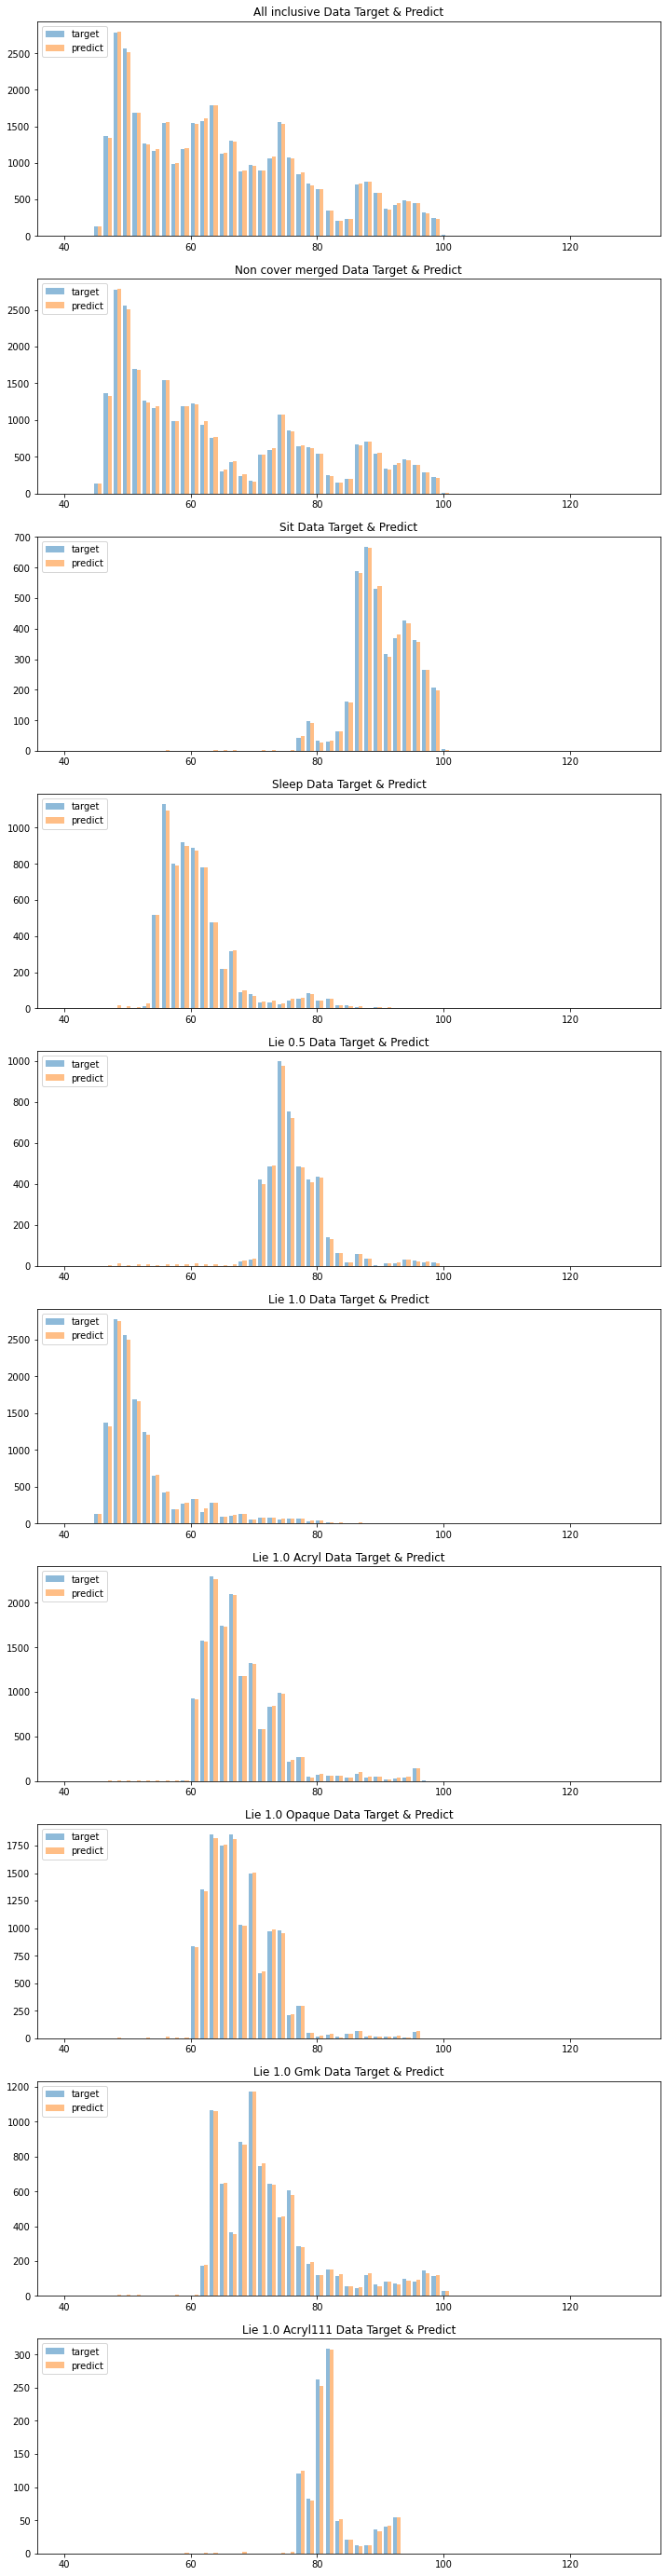

In [ ]:
# 타겟값 예측값 히스토그램
log_trans_knn_predict_merged_test = log_trans_merged_knn_search.predict(merged_X_test)
log_trans_knn_predict_non_cover_merged_test = log_trans_merged_knn_search.predict(non_cover_merged_X_test)
log_trans_knn_predict_sit_test = log_trans_merged_knn_search.predict(sit_X_test)
log_trans_knn_predict_sleep_test = log_trans_merged_knn_search.predict(sleep_X_test)
log_trans_knn_predict_lie_05_test = log_trans_merged_knn_search.predict(lie_05_X_test)
log_trans_knn_predict_lie_10_test = log_trans_merged_knn_search.predict(lie_10_X_test)
log_trans_knn_predict_lie_10_acryl = log_trans_merged_knn_search.predict(lie_10_acryl_X)
log_trans_knn_predict_lie_10_opaque = log_trans_merged_knn_search.predict(lie_10_opaque_X)
log_trans_knn_predict_lie_10_gmk = log_trans_merged_knn_search.predict(lie_10_gmk_X)
log_trans_knn_predict_lie_10_acryl111 = log_trans_merged_knn_search.predict(lie_10_acryl111_X)

bins = np.linspace(40, 130, 60)
plt.figure(figsize=(12, 50))

plt.subplot(10, 1, 1)
plt.title('All inclusive Data Target & Predict')
plt.hist([merged_y_test, log_trans_knn_predict_merged_test], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(10, 1, 2)
plt.title('Non cover merged Data Target & Predict')
plt.hist([non_cover_merged_y_test, log_trans_knn_predict_non_cover_merged_test], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(10, 1, 3)
plt.title('Sit Data Target & Predict')
plt.hist([sit_y_test, log_trans_knn_predict_sit_test], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(10, 1, 4)
plt.title('Sleep Data Target & Predict')
plt.hist([sleep_y_test, log_trans_knn_predict_sleep_test], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(10, 1, 5)
plt.title('Lie 0.5 Data Target & Predict')
plt.hist([lie_05_y_test, log_trans_knn_predict_lie_05_test], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(10, 1, 6)
plt.title('Lie 1.0 Data Target & Predict')
plt.hist([lie_10_y_test, log_trans_knn_predict_lie_10_test], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(10, 1, 7)
plt.title('Lie 1.0 Acryl Data Target & Predict')
plt.hist([lie_10_acryl_y, log_trans_knn_predict_lie_10_acryl], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(10, 1, 8)
plt.title('Lie 1.0 Opaque Data Target & Predict')
plt.hist([lie_10_opaque_y, log_trans_knn_predict_lie_10_opaque], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(10, 1, 9)
plt.title('Lie 1.0 Gmk Data Target & Predict')
plt.hist([lie_10_gmk_y, log_trans_knn_predict_lie_10_gmk], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(10, 1, 10)
plt.title('Lie 1.0 Acryl111 Data Target & Predict')
plt.hist([lie_10_acryl111_y, log_trans_knn_predict_lie_10_acryl111], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.show()

###(2.2) Extra trees

In [ ]:
merged_et_model = ET_Regressor()

merged_et_search = GridSearchCV(merged_et_model, grid_params_et, scoring = "neg_mean_squared_error",
                      cv = cv, n_jobs = -1, verbose = 1)

log_trans_merged_et_search = TransformedTargetRegressor(regressor = merged_et_search, func = np.log1p, inverse_func = np.expm1)

log_trans_merged_et_search.fit(merged_X_train, merged_y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=2, test_size=0.3, train_size=None),
                                                  estimator=Pipeline(steps=[('scaler',
                                                                             StandardScaler()),
                                                                            ('model',
                                                                             ExtraTreesRegressor(random_state=2))]),
                                                  n_jobs=-1,
                                                  param_grid=[{'model__max_depth': [None,
                                                                                    10,
                                                                                    20,
                                                                                 

In [ ]:
print(log_trans_merged_et_search.regressor_.best_params_)

{'model__max_depth': None, 'model__n_estimators': 500}


In [ ]:
evaluate_model(log_trans_merged_et_search, for_predict_X_list, for_predict_y_list, data_name = data_name)

====All inclusive data====
R squared:  0.9927898847540692
MSE:  1.3927829669205687

====Non cover merged data====
R squared:  0.9936996336528149
MSE:  1.419363952608684

====Sit data====
R squared:  0.8985107497690668
MSE:  2.2093275380375417

====Sleep data====
R squared:  0.977489301165467
MSE:  0.7869255790919778

====Lie 0.5 data====
R squared:  0.8784066994103114
MSE:  2.546134694078469

====Lie 1.0 data====
R squared:  0.9750598850912968
MSE:  1.0992168694153748

====Lie 1.0 Acryl data====
R squared:  0.967916200251311
MSE:  1.2196562447235795

====Lie 1.0 Opaque data====
R squared:  0.9716241403146081
MSE:  0.8462448296277792

====Lie 1.0 Gmk data====
R squared:  0.9729209510452372
MSE:  1.9592011888439052

====Lie 1.0 Acryl111 data====
R squared:  0.8179852487179003
MSE:  2.7970211258508733



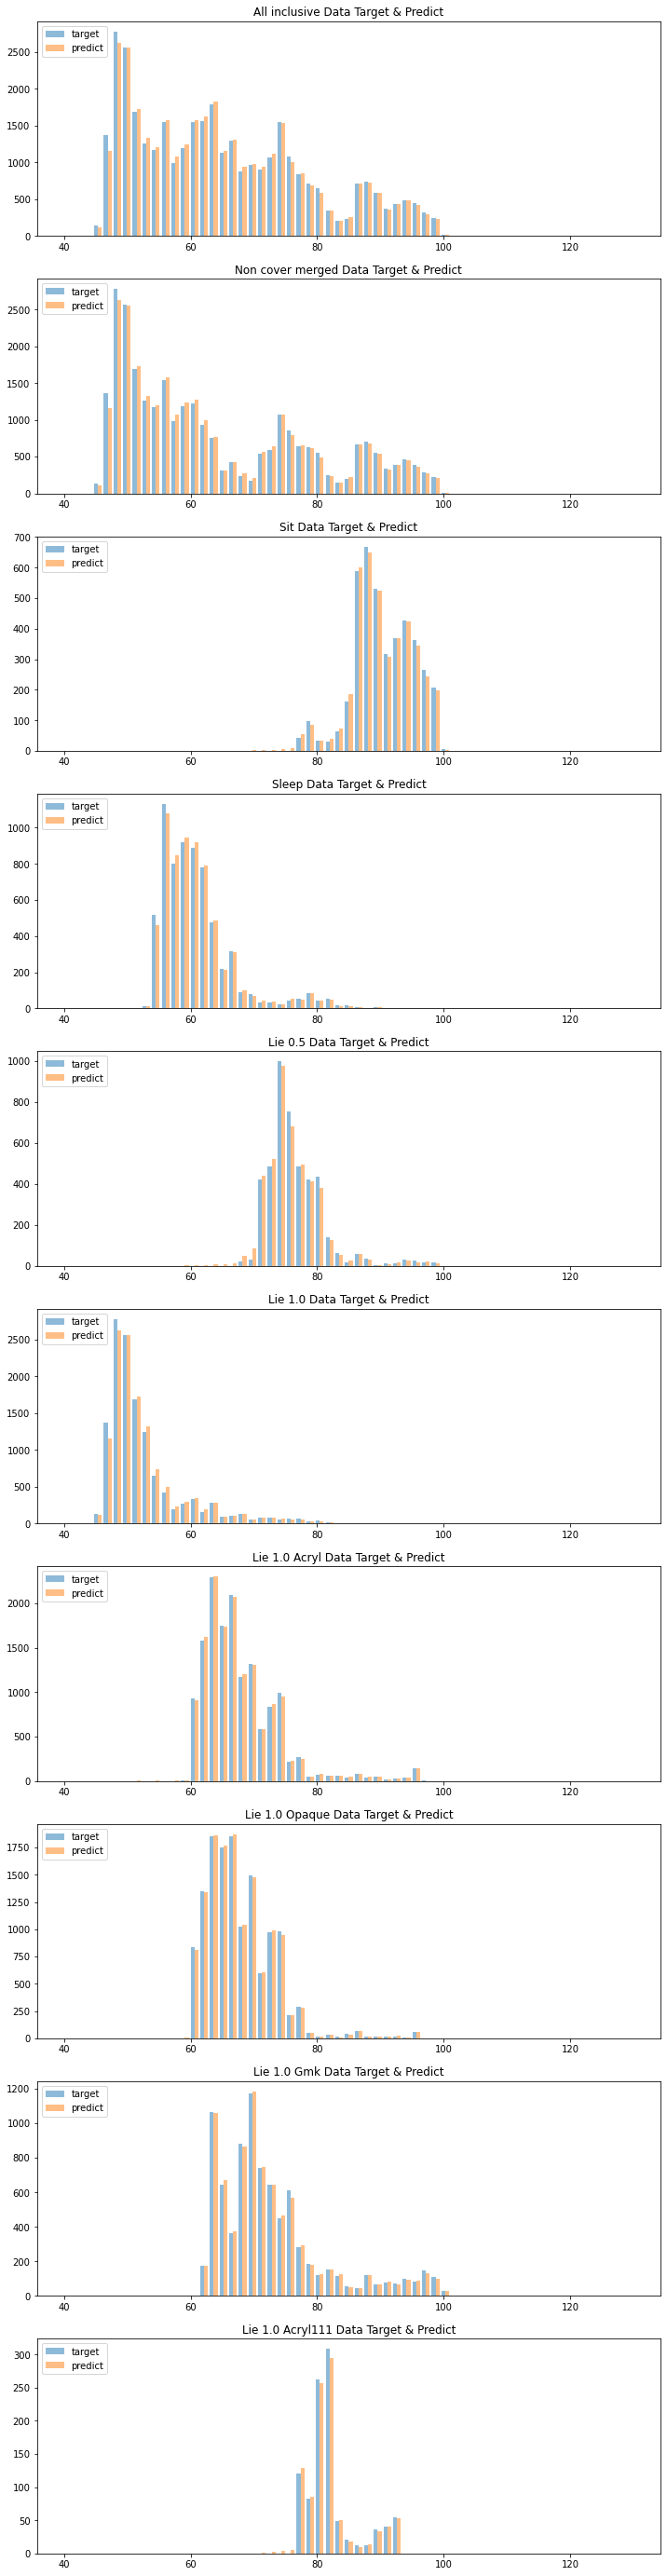

In [ ]:
# 타겟값 예측값 히스토그램
log_trans_et_predict_merged_test = log_trans_merged_et_search.predict(merged_X_test)
log_trans_et_predict_non_cover_merged_test = log_trans_merged_et_search.predict(non_cover_merged_X_test)
log_trans_et_predict_sit_test = log_trans_merged_et_search.predict(sit_X_test)
log_trans_et_predict_sleep_test = log_trans_merged_et_search.predict(sleep_X_test)
log_trans_et_predict_lie_05_test = log_trans_merged_et_search.predict(lie_05_X_test)
log_trans_et_predict_lie_10_test = log_trans_merged_et_search.predict(lie_10_X_test)
log_trans_et_predict_lie_10_acryl = log_trans_merged_et_search.predict(lie_10_acryl_X)
log_trans_et_predict_lie_10_opaque = log_trans_merged_et_search.predict(lie_10_opaque_X)
log_trans_et_predict_lie_10_gmk = log_trans_merged_et_search.predict(lie_10_gmk_X)
log_trans_et_predict_lie_10_acryl111 = log_trans_merged_et_search.predict(lie_10_acryl111_X)

bins = np.linspace(40, 130, 60)
plt.figure(figsize=(12, 50))

plt.subplot(10, 1, 1)
plt.title('All inclusive Data Target & Predict')
plt.hist([merged_y_test, log_trans_et_predict_merged_test], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(10, 1, 2)
plt.title('Non cover merged Data Target & Predict')
plt.hist([non_cover_merged_y_test, log_trans_et_predict_non_cover_merged_test], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(10, 1, 3)
plt.title('Sit Data Target & Predict')
plt.hist([sit_y_test, log_trans_et_predict_sit_test], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(10, 1, 4)
plt.title('Sleep Data Target & Predict')
plt.hist([sleep_y_test, log_trans_et_predict_sleep_test], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(10, 1, 5)
plt.title('Lie 0.5 Data Target & Predict')
plt.hist([lie_05_y_test, log_trans_et_predict_lie_05_test], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(10, 1, 6)
plt.title('Lie 1.0 Data Target & Predict')
plt.hist([lie_10_y_test, log_trans_et_predict_lie_10_test], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(10, 1, 7)
plt.title('Lie 1.0 Acryl Data Target & Predict')
plt.hist([lie_10_acryl_y, log_trans_et_predict_lie_10_acryl], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(10, 1, 8)
plt.title('Lie 1.0 Opaque Data Target & Predict')
plt.hist([lie_10_opaque_y, log_trans_et_predict_lie_10_opaque], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(10, 1, 9)
plt.title('Lie 1.0 Gmk Data Target & Predict')
plt.hist([lie_10_gmk_y, log_trans_et_predict_lie_10_gmk], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(10, 1, 10)
plt.title('Lie 1.0 Acryl111 Data Target & Predict')
plt.hist([lie_10_acryl111_y, log_trans_et_predict_lie_10_acryl111], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.show()

###(2.3) Random Forest

In [ ]:
merged_rfr_model = RFR_Regressor()

merged_rfr_search = GridSearchCV(merged_rfr_model, grid_params_et, scoring = "neg_mean_squared_error",
                      cv = cv, n_jobs = -1, verbose = 1)

log_trans_merged_rfr_search = TransformedTargetRegressor(regressor = merged_rfr_search, func = np.log1p, inverse_func = np.expm1)

log_trans_merged_rfr_search.fit(merged_X_train, merged_y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=2, test_size=0.3, train_size=None),
                                                  estimator=Pipeline(steps=[('scaler',
                                                                             StandardScaler()),
                                                                            ('model',
                                                                             RandomForestRegressor())]),
                                                  n_jobs=-1,
                                                  param_grid=[{'model__max_depth': [None,
                                                                                    10,
                                                                                    20,
                                                                                    30,
     

In [ ]:
print(log_trans_merged_rfr_search.regressor_.best_params_)

{'model__max_depth': 50, 'model__n_estimators': 500}


In [ ]:
evaluate_model(log_trans_merged_rfr_search, for_predict_X_list, for_predict_y_list, data_name = data_name)

====All inclusive data====
R squared:  0.9884052896966784
MSE:  2.2397582377006713

====Non cover merged data====
R squared:  0.9899721660298808
MSE:  2.2590981659806317

====Sit data====
R squared:  0.8499917907937012
MSE:  3.2655406043206603

====Sleep data====
R squared:  0.9616715304102357
MSE:  1.339880798430143

====Lie 0.5 data====
R squared:  0.8185600352134071
MSE:  3.7993095589568684

====Lie 1.0 data====
R squared:  0.9574930069429772
MSE:  1.873463855617459

====Lie 1.0 Acryl data====
R squared:  0.9483214259588215
MSE:  1.9645458468586954

====Lie 1.0 Opaque data====
R squared:  0.9481972521655296
MSE:  1.5448979520433777

====Lie 1.0 Gmk data====
R squared:  0.9570061685633144
MSE:  3.110654506531088

====Lie 1.0 Acryl111 data====
R squared:  0.6362131398118167
MSE:  5.590313565719084



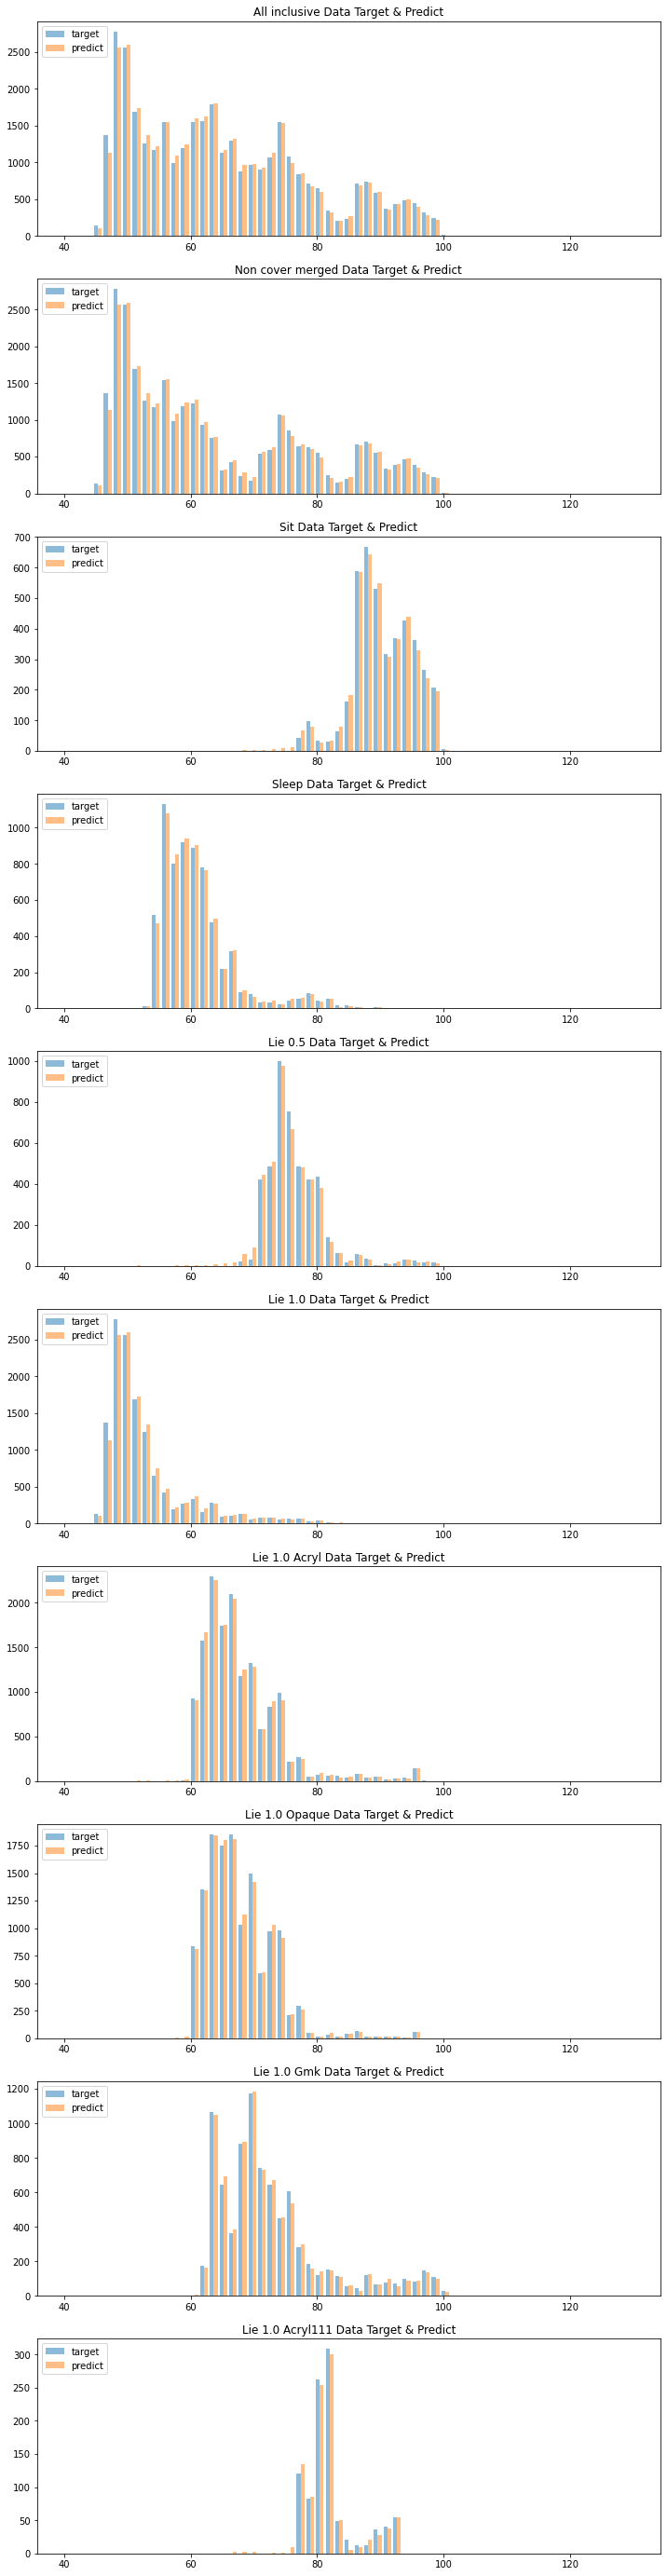

In [ ]:
# 타겟값 예측값 히스토그램
log_trans_rfr_predict_merged_test = log_trans_merged_rfr_search.predict(merged_X_test)
log_trans_rfr_predict_non_cover_merged_test = log_trans_merged_rfr_search.predict(non_cover_merged_X_test)
log_trans_rfr_predict_sit_test = log_trans_merged_rfr_search.predict(sit_X_test)
log_trans_rfr_predict_sleep_test = log_trans_merged_rfr_search.predict(sleep_X_test)
log_trans_rfr_predict_lie_05_test = log_trans_merged_rfr_search.predict(lie_05_X_test)
log_trans_rfr_predict_lie_10_test = log_trans_merged_rfr_search.predict(lie_10_X_test)
log_trans_rfr_predict_lie_10_acryl = log_trans_merged_rfr_search.predict(lie_10_acryl_X)
log_trans_rfr_predict_lie_10_opaque = log_trans_merged_rfr_search.predict(lie_10_opaque_X)
log_trans_rfr_predict_lie_10_gmk = log_trans_merged_rfr_search.predict(lie_10_gmk_X)
log_trans_rfr_predict_lie_10_acryl111 = log_trans_merged_rfr_search.predict(lie_10_acryl111_X)

bins = np.linspace(40, 130, 60)
plt.figure(figsize=(12, 50))

plt.subplot(10, 1, 1)
plt.title('All inclusive Data Target & Predict')
plt.hist([merged_y_test, log_trans_rfr_predict_merged_test], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(10, 1, 2)
plt.title('Non cover merged Data Target & Predict')
plt.hist([non_cover_merged_y_test, log_trans_rfr_predict_non_cover_merged_test], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(10, 1, 3)
plt.title('Sit Data Target & Predict')
plt.hist([sit_y_test, log_trans_rfr_predict_sit_test], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(10, 1, 4)
plt.title('Sleep Data Target & Predict')
plt.hist([sleep_y_test, log_trans_rfr_predict_sleep_test], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(10, 1, 5)
plt.title('Lie 0.5 Data Target & Predict')
plt.hist([lie_05_y_test, log_trans_rfr_predict_lie_05_test], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(10, 1, 6)
plt.title('Lie 1.0 Data Target & Predict')
plt.hist([lie_10_y_test, log_trans_rfr_predict_lie_10_test], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(10, 1, 7)
plt.title('Lie 1.0 Acryl Data Target & Predict')
plt.hist([lie_10_acryl_y, log_trans_rfr_predict_lie_10_acryl], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(10, 1, 8)
plt.title('Lie 1.0 Opaque Data Target & Predict')
plt.hist([lie_10_opaque_y, log_trans_rfr_predict_lie_10_opaque], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(10, 1, 9)
plt.title('Lie 1.0 Gmk Data Target & Predict')
plt.hist([lie_10_gmk_y, log_trans_rfr_predict_lie_10_gmk], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.subplot(10, 1, 10)
plt.title('Lie 1.0 Acryl111 Data Target & Predict')
plt.hist([lie_10_acryl111_y, log_trans_rfr_predict_lie_10_acryl111], bins, alpha = 0.5, label = ['target', 'predict'])
plt.legend(loc='upper left')

plt.show()